k2-k4 does not generate positive synergy. This is intuitive: for the TF that acts on k4 (TF4) to have an effect, it needs to be bound to state 2. However, for the TF that acts on k2 (TF2) to have an effect, it also needs to bind to state 2. It seems that if TF4 unbinds from state2, then the system probably reverts back to state 1 before TF2 can bind. However, when there is a step in between the steps controlled by each TF, they can complement each other. Doublecheck the intuition by plotting the paths of dominant fluxes for the parameter sets from the boundary search.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
sys.path.append("../../../work2/ownutils/scriptssyn") #rosamc/scriptssyn repo
sys.path.append("./bin/")
import PolAB_A_allpars

import networkx as nx
import matplotlib as mpl
mpl.rcParams['font.size']=12
import fluxes
import clusteringaux
import basic
import glob
import itertools
import matplotlib.colors as colors
import seaborn as sns

In [2]:
rhofunc=PolAB_A_allpars.interface_rhos_GRF_PolAB_A_A
parsliststr='ktia0,ktan0,ktin0,ktni0,ktiaA,ktanA,ktinA,ktniA,ktiaB,ktanB,ktinB,ktniB,kbBa,kuBa,kbBi,kuBi,kbBn,kuBn,kbAa,kuAa,kbAi,kuAi,kbAn,kuAn'
parslist=parsliststr.split(',')
parslist_order=['ktni0','ktin0','ktia0','ktan0','ktniA','ktinA','ktiaA','ktanA','ktniB','ktinB','ktiaB','ktanB','kbBa','kuBa','kbBi','kuBi','kbBn','kuBn','kbAa','kuAa','kbAi','kuAi','kbAn','kuAn']
flux_order_labs=['2-1','1-2','1-0','0-2','5-4','4-5','4-3','3-5','8-7','7-8','7-6','6-8','2-5','5-2','2-8','8-2','1-4','4-1','1-7','7-1','0-3','3-0','0-6','6-0']

#labls=np.array(parslist[:18])

#copied from 2019_05_14_prepare_3statepol-equalb

edges=[(2,'ktia0',1),(1,'ktan0',3),(2,'ktin0',3),(3,'ktni0',2),
       (8,'ktiaA',7),(7,'ktanA',9),(8,'ktinA',9),(9,'ktniA',8),
       (5,'ktiaB',4),(4,'ktanB',6),(5,'ktinB',6),(6,'ktniB',5),
      (1,'kbBa-B',4),(4,'kuBa',1),(2,'kbBi-B',5),(5,'kuBi',2),(3,'kbBn-B',6),(6,'kuBn',3),
       (1,'kbAa-A',7),(7,'kuAa',1),(2,'kbAi-A',8),(8,'kuAi',2),(3,'kbAn-A',9),(9,'kuAn',3)]
edges_=[]
for tuple_ in edges:
    edges_.append((tuple_[0]-1,tuple_[1],tuple_[2]-1))
    
graph_edges_dict=dict()
for x in edges:
    graph_edges_dict['%s-%s'%(x[0],x[2])]=x[1]
#note that A is to the left, B is to the right
#coords=fluxes.get_G_coords_9nodes()
basiccoords={0: [0,-1],
         1: [0.,1],
         2: [-1, 0]}

dx=2.5
coords=dict()
coords[0]=basiccoords[0]
coords[1]=basiccoords[1]
coords[2]=basiccoords[2]
coords[3]=[basiccoords[0][0]+dx,basiccoords[0][1]] #B
coords[4]=[basiccoords[1][0]+dx,basiccoords[1][1]] #B
coords[5]=[basiccoords[2][0]+dx,basiccoords[2][1]] #B
coords[6]=[basiccoords[0][0]-dx,basiccoords[0][1]] #A
coords[7]=[basiccoords[1][0]-dx,basiccoords[1][1]] #A
coords[8]=[basiccoords[2][0]-dx,basiccoords[2][1]] #A


#connectstyles

#these are the labels corresponding to the flux matrix, then flattened so that it is a row
nnodes=9
flux_names_mat=np.empty((nnodes,nnodes),dtype=object)
for i in np.arange(nnodes):
    for j in np.arange(nnodes):
        flux_names_mat[i,j]='%d-%d'%(i,j)
#print(flux_names_mat)
flux_names_flat=flux_names_mat.flatten()
#print(flux_names_flat)

#names of transitions for the fluxes, appending an extension to distinguish the different TF states
#for this analysis I only look at the situation where both TFs are present, but could also look at the situation where, nothing, or only A or B are bound
all_fnames=[]
flux_order_labs_AB=[]
for i in [3]:
    if i==0:
        ext='0'
    elif i==1:
        ext='A'
    elif i==2:
        ext='B'
    else:
        ext='AB'
    all_fnames.extend(['%s.%s'%(x,ext) for x in flux_names_flat]) #add extension to the labls obtained above
    flux_order_labs_AB.extend(['%s.%s'%(x,ext) for x in flux_order_labs]) #add extension to the order
all_fnames=np.array(all_fnames)

#find the edges that are mirror images of each other
edges_sym=dict()
for edge_ in edges:
    edge=edge_[1]
    if "A" in edge:
        e2=edge.replace("A","B")
    elif "B" in edge:
        e2=edge.replace("B","A")
    else:
        continue
    for e_ in edges:
        if e_[1]==e2:
            nodes1="%d-%d"%(edge_[0]-1,edge_[2]-1)
            nodes="%d-%d"%(e_[0]-1,e_[2]-1)
            print(nodes1, edge_, "symmetric of", e_,nodes)
            edges_sym[nodes1]=nodes

7-6 (8, 'ktiaA', 7) symmetric of (5, 'ktiaB', 4) 4-3
6-8 (7, 'ktanA', 9) symmetric of (4, 'ktanB', 6) 3-5
7-8 (8, 'ktinA', 9) symmetric of (5, 'ktinB', 6) 4-5
8-7 (9, 'ktniA', 8) symmetric of (6, 'ktniB', 5) 5-4
4-3 (5, 'ktiaB', 4) symmetric of (8, 'ktiaA', 7) 7-6
3-5 (4, 'ktanB', 6) symmetric of (7, 'ktanA', 9) 6-8
4-5 (5, 'ktinB', 6) symmetric of (8, 'ktinA', 9) 7-8
5-4 (6, 'ktniB', 5) symmetric of (9, 'ktniA', 8) 8-7
0-3 (1, 'kbBa-B', 4) symmetric of (1, 'kbAa-A', 7) 0-6
3-0 (4, 'kuBa', 1) symmetric of (7, 'kuAa', 1) 6-0
1-4 (2, 'kbBi-B', 5) symmetric of (2, 'kbAi-A', 8) 1-7
4-1 (5, 'kuBi', 2) symmetric of (8, 'kuAi', 2) 7-1
2-5 (3, 'kbBn-B', 6) symmetric of (3, 'kbAn-A', 9) 2-8
5-2 (6, 'kuBn', 3) symmetric of (9, 'kuAn', 3) 8-2
0-6 (1, 'kbAa-A', 7) symmetric of (1, 'kbBa-B', 4) 0-3
6-0 (7, 'kuAa', 1) symmetric of (4, 'kuBa', 1) 3-0
1-7 (2, 'kbAi-A', 8) symmetric of (2, 'kbBi-B', 5) 1-4
7-1 (8, 'kuAi', 2) symmetric of (5, 'kuBi', 2) 4-1
2-8 (3, 'kbAn-A', 9) symmetric of (3, 'kbBn-B'

In [3]:
def check_constraints(df,minb=None,maxb=None,parfc=None,fc1=None,fc2=None):
    for par in ["p1","p2","p4"]:
        minb_=10**minb
        maxb_=10**maxb
        print(minb_,maxb_)
        mask=(df[par].values>=minb_) & (df[par].values<=maxb_)
        checkb1=np.all(mask)
        print("base clockwise", checkb1)
        if not checkb1:
            display(df[~mask])
        
    ktinlim=4-(maxb-minb)
    print("ktin>%d? "%ktinlim, np.all(df["p3"].values >=ktinlim))
    
    
    r1A=df["p5"]/df["p1"]
    r2A=df["p6"]/df["p2"]
    r3A=df["p8"]/df["p4"]
    r1B=df["p9"]/df["p1"]
    r2B=df["p10"]/df["p2"]
    r3B=df["p12"]/df["p4"]
    
    r4A=df["p7"]/df["p3"]
    r4B=df["p11"]/df["p3"]
    
    
    if parfc is None:
        for r_,r in enumerate([r1A,r2A,r3A,r1B,r2B,r3B]):
            print("clockwise par",r_,"gt1",np.all(r.values>1),"gteq1",np.all(r.values>=1))
        for r_,r in enumerate([r4A,r4B]):
            print("anticlockwise par", r_,"lt1",np.all(r.values<1),"lteq1",np.all(r.values<=1))
    else:
        parfc_=10**parfc
        titles=["r1A","r2A","r3A","r1B","r2B","r3B"]
        for r_,r in enumerate([r1A,r2A,r3A,r1B,r2B,r3B]):
            print("clockwise par",titles[r_],"eq1",np.all(r.values==1),"gt1",np.all(r.values>1),"eqgt1",np.all(r.values>=1-1e-10),"eqgt1 and fc",np.all((r.values>=1)&(r.values<=parfc_)))
        for r_,r in enumerate([r4A,r4B]):
            print("anticlockwise par", r_,"eq1",np.all(r.values==1),"lt1",np.all(r.values<1),"leq1",np.all(r.values<=1+1e-10),np.all((r.values<1)&(r.values>=1/parfc_)))
    print("fc1 A", np.all((df["mA"]/df["m0"]).values<fc1))
    print("fc1 B", np.all((df["mB"]/df["m0"]).values<fc1))
    print("fc2", np.all((df["mA"]/df["mB"]).values<=fc2))
    
    return 
        
        
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Read data

In [4]:
def return_fullparset(parset,case):
    if case=="any":
        parset2=parset.copy()
    elif case=="difAD_difbnp":
        parset2=np.concatenate((parset[0:12],parset[12:14],parset[12:14],parset[12:14],parset[14:16],parset[14:16],parset[14:16]))
    elif case=="difADsbnp" or case=="difAD_samebnp":
        parset2=np.concatenate((parset[0:12],parset[12:14],parset[12:14],parset[12:14],parset[12:14],parset[12:14],parset[12:14]))
    elif case=="difAD_samebnp_step12":#ni,ia
        parset2=np.concatenate((parset[0:4],parset[0:3],parset[4:5],parset[5:6],parset[1:4],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8]))
    elif case=="difAD_samebnp_step13": #ni,an
        parset2=np.concatenate((parset[0:4],parset[0:3],parset[4:5],parset[0:1],parset[5:6],parset[2:4],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8]))    
    elif case=="difAD_samebnp_step42": #in,ia #4,2
        parset2=np.concatenate((parset[0:4],parset[0:2],parset[4:5],parset[3:4],parset[5:6],parset[1:4],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8]))    
    elif case=="difAD_samebnp_step43": #in,an #4,3
        parset2=np.concatenate((parset[0:4],parset[0:2],parset[4:5],parset[3:4],parset[0:1],parset[5:6],parset[2:4],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8]))    
    elif case=="difAD_samebnp_step23":#ia,an
        parset2=np.concatenate((parset[0:4],parset[4:5],parset[1:4],parset[0:1],parset[5:6],parset[2:4],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8]))    
    elif case=="difAD_samebnp_step11":
        parset2=np.concatenate((parset[0:4],parset[0:3],parset[4:5],parset[0:3],parset[5:6],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8]))
    elif case=="difAD_samebnp_step22":
        parset2=np.concatenate((parset[0:4],parset[4:5],parset[1:4],parset[5:6],parset[1:4],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8],parset[6:8]))
    elif case=="sameAD_difbp":
        parset2=np.concatenate((parset[0:8],parset[4:8],parset[8:20]))
    elif case=="sameAD_difbp_kuonly":
        kb=parset[8]
        ku1,ku2,ku3,ku4,ku5,ku6=parset[9:]
        bindingar=np.array([kb,ku1,kb,ku2,kb,ku3,kb,ku4,kb,ku5,kb,ku6])
        parset2=np.concatenate((parset[0:8],parset[4:8],bindingar))
    elif case=="sameAD_difbnp":
        parset2=np.concatenate((parset[0:8],parset[4:8],parset[8:10],parset[8:10],parset[8:10],parset[10:12],parset[10:12],parset[10:12]))
    elif case=="empty":
         parset2=np.concatenate((parset[0:8],parset[0:4],parset[8:10],parset[8:10],parset[8:10],parset[8:10],parset[8:10],parset[8:10]))
    else:
        print("unrecognised case, ", case)
        raise ValueError
    return parset2

In [5]:
colnames=["p%d"%i for i in range(1,25)]
colnames=colnames+["SAB","SBA","m0","mA","mB","mAB","quadrant"]
colnames

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p16',
 'p17',
 'p18',
 'p19',
 'p20',
 'p21',
 'p22',
 'p23',
 'p24',
 'SAB',
 'SBA',
 'm0',
 'mA',
 'mB',
 'mAB',
 'quadrant']

In [6]:
f1="/Users/rosamartinezcorral/Dropbox (HMS)/data/magic-kinsynsub1/2022_03_11_boundaries_k4k2_k4k3_0_4_1000_10"
fc1=10
fc2=10
minb=0
maxb=4
parfc=3
alldfs=[]


green="#c6cdad"
blue="#d3dbe4"
red="#e3cbc8"

green2="#b1bc8c"
blue2="#a6bed8"

for initial in [0,12]:
    if initial==0:
        case="difAD_samebnp_step42"
        name="mat_difAD_samebnp_step42_fcd=0.001_fcu=1000_fc1=10_fc2=10"
    else:
        case="difAD_samebnp_step43"
        name="mat_difAD_samebnp_step43_fcd=0.001_fcu=1000_fc1=10_fc2=10"
    allrows=[]
    for i in range(initial,initial+12):
        fmat=os.path.join(f1,"final_results","%s_%d_last.npy"%(name,i))
        fmatpars=fmat.replace("mat","mat_pars")
        mat=np.load(fmat)
        matpars=np.load(fmatpars)
        for r in range(len(mat)):
            for c in range(len(mat[0])):
                if mat[r,c]>0:
                    parset=matpars[r,c].copy()
                    fullpars=return_fullparset(parset,case)
                    SAB,SBA,mstars=basic.compute_synergy(fullpars,PolAB_A_allpars.interface_GRF_PolAB_A_A,returnm=True,anystronger=True)
                    if mstars[2]>mstars[1]:
                        #change order
                        SAB_=SAB
                        SAB=SBA
                        SBA=SAB_
                        m0=mstars[0]
                        mA=mstars[2]
                        mB=mstars[1]
                        mAB=mstars[3]
                    else:
                        m0,mA,mB,mAB=mstars
                        
                    if SAB>0 and SBA>0:
                        quadrant=1
                    elif SAB<0 and SBA>0:
                        quadrant=2
                    else:
                        quadrant=3
                    allrows.append(list(fullpars)+[SAB,SBA]+[m0,mA,mB,mAB]+[quadrant])
    df=pd.DataFrame(data=allrows,columns=colnames)
                    
    display(df.head())
    ok=check_constraints(df,minb=minb,maxb=maxb,parfc=parfc,fc1=fc1,fc2=fc2)
    alldfs.append(df)

p1            p2         p3        p4        p5            p6  \
0  1.000000   3975.908653  21.016227  1.000000  1.000000   3975.908653   
1  2.340402      1.000000  80.464051  1.000000  2.340402      1.000000   
2  2.340402      1.000000  80.464051  1.000000  2.340402      1.000000   
3  2.340402      1.000000  80.464051  1.160389  2.340402      1.000000   
4  1.000000  10000.000000  46.988776  1.002109  1.000000  10000.000000   

          p7        p8         p9           p10  ...          p22      p23  \
0  21.016227  1.000000   1.000000   3975.908653  ...  1073.085599  10000.0   
1   1.035454  1.000000  36.377769      1.000000  ...   507.024376  10000.0   
2   1.103980  1.000000  36.377769      1.000000  ...   507.024376  10000.0   
3   1.035454  1.160389  36.377769      1.000000  ...   507.024376  10000.0   
4   1.000000  1.002109  11.088629  10000.000000  ...   862.553522  10000.0   

           p24       SAB           SBA        m0        mA        mB  \
0  1073.085599  0.000000  3.203427e-16  0.043447  0.043447  0.043447   
1   507.024376 -0.197332  1.476586e-02  0.027168  0.269859  0.232964   
2   507.024376 -0.186979  1.404199e-02  0.027168  0.267795  0.232964   
3   507.024376 -0.167345  1.265879e-02  0.031331  0.294922  0.260328   
4   862.553522 -0.151758  1.430052e-02  0.020455  0.204529  0.182292   

        mAB  quadrant  
0  0.043447         3  
1  0.235360         2  
2  0.235242         2  
3  0.262622         2  
4  0.184108         2  

[5 rows x 31 columns]

1 10000
base clockwise True
1 10000
base clockwise True
1 10000
base clockwise True
ktin>0?  True
clockwise par r1A eq1 True gt1 False eqgt1 True eqgt1 and fc True
clockwise par r2A eq1 True gt1 False eqgt1 True eqgt1 and fc True
clockwise par r3A eq1 True gt1 False eqgt1 True eqgt1 and fc True
clockwise par r1B eq1 False gt1 False eqgt1 True eqgt1 and fc False
clockwise par r2B eq1 True gt1 False eqgt1 True eqgt1 and fc True
clockwise par r3B eq1 True gt1 False eqgt1 True eqgt1 and fc True
anticlockwise par 0 eq1 False lt1 False leq1 True False
anticlockwise par 1 eq1 True lt1 False leq1 True False
fc1 A True
fc1 B True
fc2 True


p1            p2            p3          p4          p5  \
0  170.258376      1.000000      1.000000  167.791898  170.258376   
1  585.977548   8477.022263     18.026927    1.000000  585.977548   
2    1.000000  10000.000000   1707.477612   81.623633    1.000000   
3  170.258376      1.000000  10000.000000    1.000000  170.258376   
4    1.000000   2422.427724      1.175855    1.000000    1.000000   

             p6           p7          p8          p9      p10  ...  \
0      1.000000     1.000000  167.791898  170.258376      1.0  ...   
1   8477.022263     1.000000    1.000000  585.977548  10000.0  ...   
2  10000.000000    39.789401   81.623633    1.000000  10000.0  ...   
3      1.000000  4500.521349    1.000000  170.258376   1000.0  ...   
4   2422.427724     1.000000    1.000000    1.000000  10000.0  ...   

           p22           p23          p24       SAB       SBA        m0  \
0   307.542786  10000.000000   307.542786  0.000000  0.000000  0.988271   
1  7265.678125  10000.000000  7265.678125 -0.015102  0.014975  0.968440   
2  1771.649330      1.000000  1771.649330 -0.001424  0.001425  0.045597   
3   304.346314      1.000000   304.346314  0.001167  0.005144  0.016464   
4    18.447196     26.372385    18.447196 -0.030381  0.029977  0.314835   

         mA        mB       mAB  quadrant  
0  0.988271  0.988271  0.988271         3  
1  0.988855  0.968453  0.978558         2  
2  0.045687  0.045597  0.045642         2  
3  0.016630  0.016584  0.016643         1  
4  0.328310  0.314858  0.321469         2  

[5 rows x 31 columns]

1 10000
base clockwise True
1 10000
base clockwise True
1 10000
base clockwise True
ktin>0?  True
clockwise par r1A eq1 True gt1 False eqgt1 True eqgt1 and fc True
clockwise par r2A eq1 True gt1 False eqgt1 True eqgt1 and fc True
clockwise par r3A eq1 True gt1 False eqgt1 True eqgt1 and fc True
clockwise par r1B eq1 True gt1 False eqgt1 True eqgt1 and fc True
clockwise par r2B eq1 False gt1 False eqgt1 True eqgt1 and fc False
clockwise par r3B eq1 True gt1 False eqgt1 True eqgt1 and fc True
anticlockwise par 0 eq1 False lt1 False leq1 True False
anticlockwise par 1 eq1 True lt1 False leq1 True False
fc1 A True
fc1 B True
fc2 True


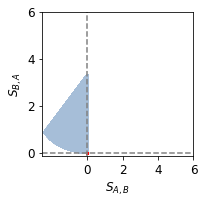

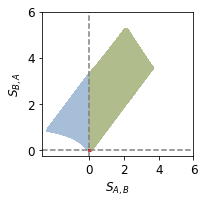

In [7]:
for df in alldfs:
    fig,ax=plt.subplots(1,1,figsize=(3,3))
    mask1=df["quadrant"]==1
    mask2=df["quadrant"]==2
    mask3=df["quadrant"]==3
    ax.scatter(df["SAB"].values[mask2],df["SBA"].values[mask2],s=3,color=blue2)
    ax.scatter(df["SAB"].values[mask1],df["SBA"].values[mask1],s=3,color=green2)
    ax.scatter(df["SAB"].values[mask3],df["SBA"].values[mask3],s=3,color="red")
    ax.set_xlabel('$S_{A,B}$')
    ax.set_ylabel('$S_{B,A}$')
    ax.axhline(y=0,linestyle="--",color="gray")
    ax.axvline(x=0,linestyle="--",color="gray")
    ax.set_xticks(np.arange(0,7,2))
    ax.set_yticks(np.arange(0,7,2))
    plt.tight_layout()
    plt.show()

In [8]:
all_fnames

array(['0-0.AB', '0-1.AB', '0-2.AB', '0-3.AB', '0-4.AB', '0-5.AB',
       '0-6.AB', '0-7.AB', '0-8.AB', '1-0.AB', '1-1.AB', '1-2.AB',
       '1-3.AB', '1-4.AB', '1-5.AB', '1-6.AB', '1-7.AB', '1-8.AB',
       '2-0.AB', '2-1.AB', '2-2.AB', '2-3.AB', '2-4.AB', '2-5.AB',
       '2-6.AB', '2-7.AB', '2-8.AB', '3-0.AB', '3-1.AB', '3-2.AB',
       '3-3.AB', '3-4.AB', '3-5.AB', '3-6.AB', '3-7.AB', '3-8.AB',
       '4-0.AB', '4-1.AB', '4-2.AB', '4-3.AB', '4-4.AB', '4-5.AB',
       '4-6.AB', '4-7.AB', '4-8.AB', '5-0.AB', '5-1.AB', '5-2.AB',
       '5-3.AB', '5-4.AB', '5-5.AB', '5-6.AB', '5-7.AB', '5-8.AB',
       '6-0.AB', '6-1.AB', '6-2.AB', '6-3.AB', '6-4.AB', '6-5.AB',
       '6-6.AB', '6-7.AB', '6-8.AB', '7-0.AB', '7-1.AB', '7-2.AB',
       '7-3.AB', '7-4.AB', '7-5.AB', '7-6.AB', '7-7.AB', '7-8.AB',
       '8-0.AB', '8-1.AB', '8-2.AB', '8-3.AB', '8-4.AB', '8-5.AB',
       '8-6.AB', '8-7.AB', '8-8.AB'], dtype='<U6')

In [10]:
min_nflog=-13
node0=2
plotting=True
nit=1000000
paths_dict=dict()

constraints=[0,4,3]
minb,maxb,parfc=constraints
fc1,fc2=[10,10]
alllabls=[]
allsubsets=[]
allmatd=[]
for i in range(2):
    df=alldfs[i]
    
    #Plot distribution of synergies per most dominant paths, irrespective of the quadrant.



    subset=df[(np.abs(df["SAB"])>0.01)&(np.abs(df["SBA"])>0.01)]
    if i==0:
        subset=subset[subset["p7"].values/subset["p3"].values<1] #keep only those where A slows down, in some cases it does nothing
        subset=subset[subset["p9"].values/subset["p1"].values>1] #and only those where B accelerates k2
    else:
        subset=subset[subset["p7"].values/subset["p3"].values<1] #keep only those where A slows down, in some cases it does nothing
        subset=subset[subset["p10"].values/subset["p2"].values>1] #and only those where B accelerates k2

    allsubsets.append(subset)
    print("npoints subset", len(subset))
    smatall,labls_=fluxes.get_mat_fluxes_abonly(subset,all_fnames,netJ=True,rhofunc=rhofunc,graph_edges=edges_)
    alllabls.append(labls_)
    mat_dominant_paths_all=fluxes.get_dominant_paths_mat_v4(smatall,labls_,node0)
    allmatd.append(mat_dominant_paths_all)


    #2. select sample, in this case all points
    subset2=subset
    SAB_values=subset2['SAB'].values
    SBA_values=subset2['SBA'].values
    quadrants=subset2["quadrant"].values
    #plt.scatter(subset2["SAB"],subset2["SBA"])
    #plt.show()
    smat=smatall #[mask]
    mat_dominant_paths=mat_dominant_paths_all #[mask]

    result=np.unique(mat_dominant_paths,axis=0,return_inverse=True,return_counts=True)
    #do not take mirrors
    
    #alluniques=fluxes.merge_mirrored_unique_paths(mat_dominant_paths,result,idxs_rev)
    #paths_dict[i]=[title,alluniques,smat,quadrants,SAB_values,SBA_values]
    paths_dict[i]=["title",result,smat,quadrants,SAB_values,SBA_values]

npoints subset 23061
npoints subset 61358


In [11]:
#Check the dominant path for a random parameter set
print(",".join(map(str,subset.iloc[10].values[0:24])))
print(smatall[10])
print(mat_dominant_paths[10])


134.26079190381967,106.02060759697567,106.22440390891018,127.02922619787364,134.26079190381967,106.02060759697567,9.015978518562882,127.02922619787364,134.26079190381967,744.0253914048808,106.22440390891018,127.02922619787364,901.9047288636611,1.0,901.9047288636611,1.0,901.9047288636611,1.0,901.9047288636611,1.0,901.9047288636611,1.0,901.9047288636611,1.0
[1.32118662e-02 8.29531001e-02 2.25392133e-02 0.00000000e+00
 0.00000000e+00 3.96918306e-03 1.53960851e-02 6.96565699e-02
 2.19031239e+01 1.11123113e-02 2.18201708e+01 0.00000000e+00
 7.18407888e-02 2.18312831e+01 7.36257529e-02 1.97216917e+01
 0.00000000e+00 1.97953174e+01 0.00000000e+00 1.97913482e+01]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]


['0-2.AB' '0-3.AB' '0-6.AB' '1-0.AB' '1-2.AB' '1-4.AB' '2-1.AB' '2-5.AB'
 '2-8.AB' '3-0.AB' '3-5.AB' '4-1.AB' '4-3.AB' '4-5.AB' '5-2.AB' '5-4.AB'
 '6-0.AB' '6-8.AB' '7-1.AB' '7-6.AB' '8-2.AB' '8-7.AB']
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.]
['1-4.AB' '2-8.AB' '4-5.AB' '5-2.AB' '7-1.AB' '8-7.AB']


<ipython-input-12-fadef1e50c63>:56: RuntimeWarning: divide by zero encountered in log10
  matnfi=np.log10(smat_)


path 2, 11560 instances
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
['1-4.AB' '2-8.AB' '3-5.AB' '4-3.AB' '5-2.AB' '7-1.AB' '8-7.AB']
path 4, 1809 instances
[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
['1-2.AB' '2-8.AB' '7-1.AB' '8-7.AB']
path 7, 1736 instances
[1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
['0-2.AB' '1-4.AB' '2-1.AB' '3-0.AB' '4-3.AB']
path 18, 1649 instances
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
['2-8.AB' '6-8.AB' '7-6.AB' '8-7.AB']
path 0, 1477 instances
[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
['1-4.AB' '2-1.AB' '3-5.AB' '4-3.AB' '5-4.AB']
path 5, 924 instances
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
['0-2.AB' '1-0.AB' '2-1.AB']
path 20, 865 instances
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
['1-4.AB' '2-8.AB' '3-5.AB' '4-3.AB' '5-4.AB' '7-1.AB' '8-7.AB']
path 3, 781 instances
[0. 0. 1. 0

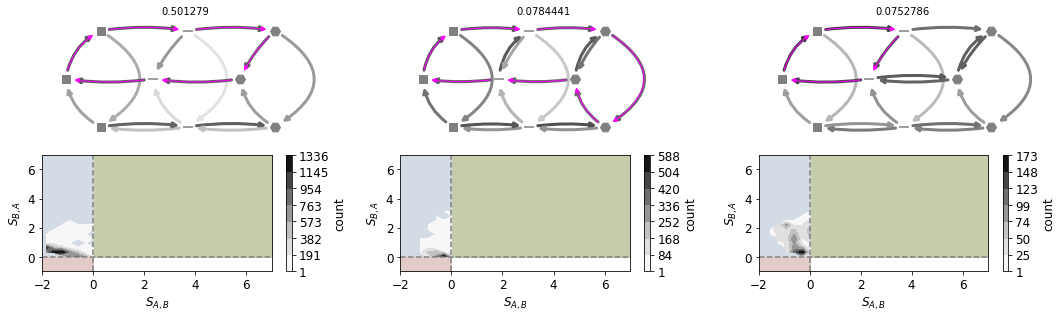

3 1 0
4 1 1
5 1 2


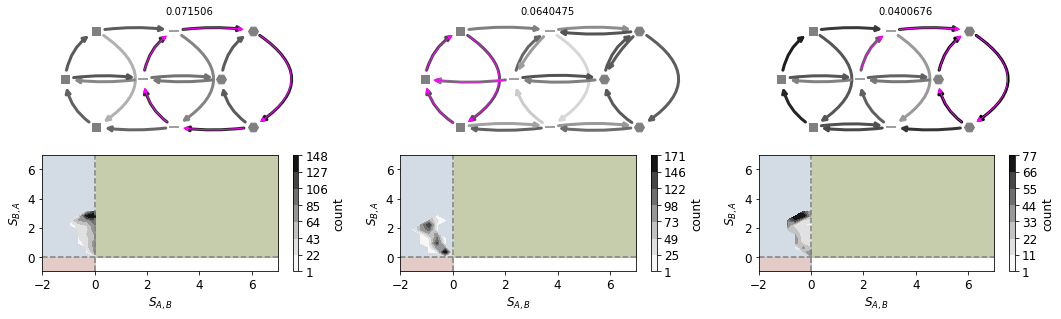

6 2 0
7 2 1
8 2 2


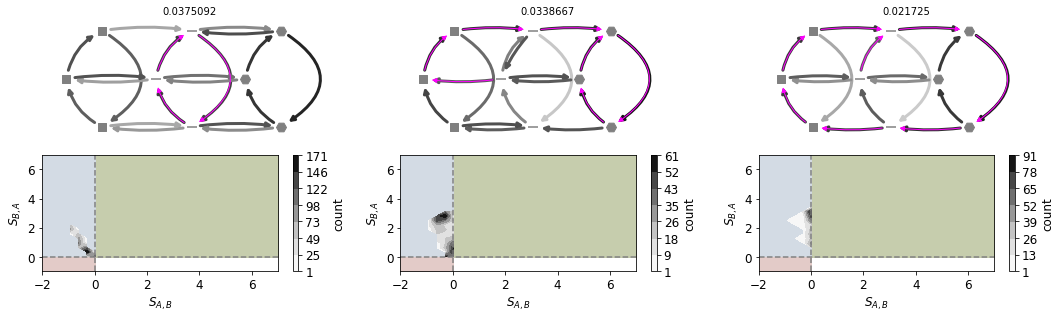

9 3 0


<ipython-input-12-fadef1e50c63>:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


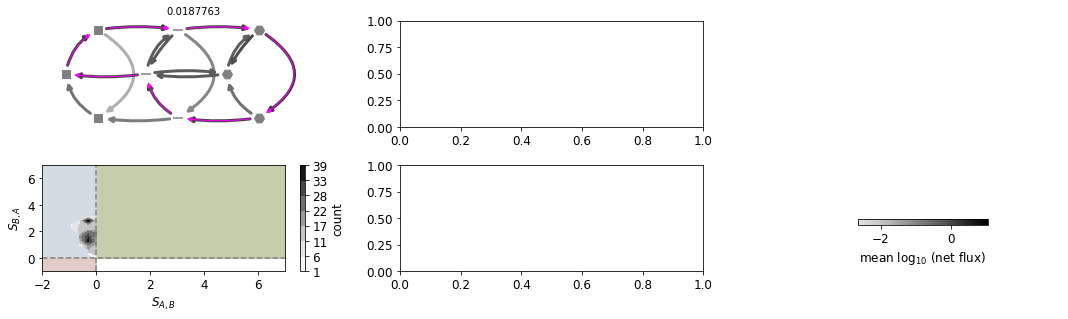

['0-2.AB' '0-3.AB' '1-0.AB' '1-2.AB' '1-4.AB' '1-7.AB' '2-1.AB' '2-8.AB'
 '3-5.AB' '4-1.AB' '4-3.AB' '4-5.AB' '5-2.AB' '5-4.AB' '6-0.AB' '6-8.AB'
 '7-1.AB' '7-6.AB' '8-2.AB' '8-7.AB']
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
['1-2.AB' '2-8.AB' '7-1.AB' '8-7.AB']
path 4, 23311 instances
[0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
['0-3.AB' '2-8.AB' '3-5.AB' '5-2.AB' '6-0.AB' '7-6.AB' '8-7.AB']
path 5, 21604 instances
[0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.]
['1-4.AB' '2-8.AB' '4-5.AB' '5-2.AB' '7-1.AB' '8-7.AB']
path 2, 9215 instances
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
['2-8.AB' '6-8.AB' '7-6.AB' '8-7.AB']
path 0, 2252 instances
first items 2
0 0 0
1 0 1
2 0 2


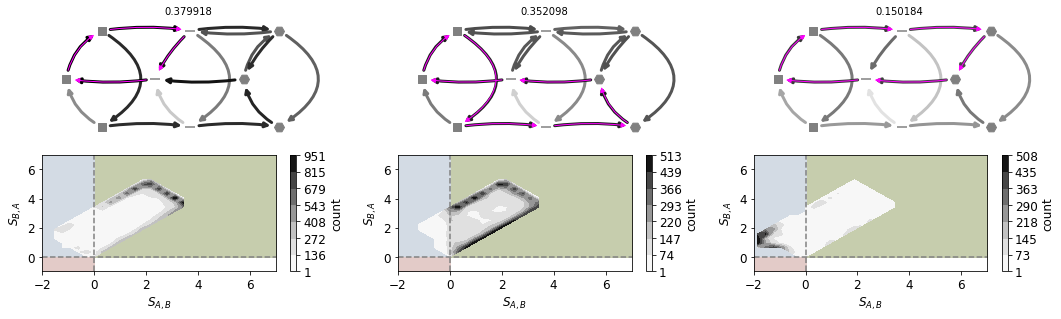

3 1 0


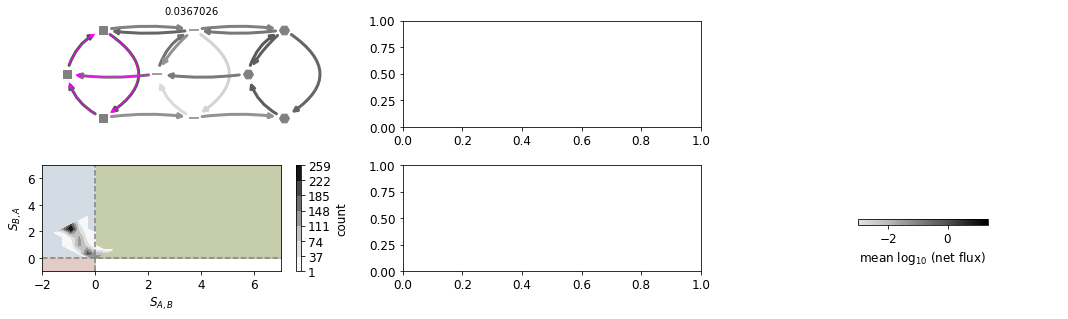

In [12]:
green="#c6cdad"
blue="#d3dbe4"
red="#e3cbc8"

xlim=7
ylim=7
cmapgreys=truncate_colormap(plt.cm.Greys,minval=0.2,maxval=1.0)


percent=0.95
for key in [0,1]:
    labls_=alllabls[key]
    print(labls_)
    #Now sort according to fluxes

    
    title,alluniques,smat,quadrants,SAB_values,SBA_values=paths_dict[key]


    #print("seed", seed, "percent", percent)
    #for q in range(3):

    unique_paths,idxsup,countup=alluniques
    total=np.sum(countup)
    argsort=np.argsort(countup)[::-1]
    counts_sorted=countup[argsort]
    #print(countup[argsort])


    m_allGs=[] #graphs for each instance with the dominant path
    dominantG=[] #dominant graphs
    corresponding_synergies=[] #corresponding synergies for each path
    percentage_positive=[]
    cumsum=np.cumsum(counts_sorted)
    threshold=np.where(cumsum>percent*total)[0][0]
    #print(cumsum)
    #print('total', total,percent*total,'threshold',threshold,countup[argsort[0:threshold]], '+1?', countup[argsort[0:threshold+1]])
    if threshold==0:
        threshold=1

    for inum,i in enumerate(argsort[0:threshold]):
        #print(inum)
        #get correaponding graph for each path

        path=unique_paths[i]

        print(path)
        print(np.array(labls_)[np.asarray(path,dtype=bool)])
        original_idxs=np.where(idxsup==i)[0] #positions where this path was
        quadrants_p=quadrants[original_idxs]
        #print("count is,", countup[i], "original indexes len is", len(original_idxs))
        #find fluxes corresponding to this path
        #smat_=smat[quadrants==q+1].copy()
        smat_=smat[original_idxs].copy()
        
        matnfi=np.log10(smat_)
        matnfi[matnfi<min_nflog]=min_nflog


        #get graphs that share this dominant path
        all_Gs=[]
        for row in matnfi:
            #Gs=[]
            J=row
            edgelabls=labls_
            G=fluxes.get_graph_fromJarray(J,edgelabls,min_=min_nflog)

            #Gs.append(G)
            #all_Gs.append(Gs)

            all_Gs.append(G)
        common_U=fluxes.merge_graphs(all_Gs)
        dominant=fluxes.get_dominant_path_G(G,node0) #since all have the same dominant path, use the last one
        m_allGs.append(common_U)
        dominantG.append(dominant)
        #allranks[q][pc].append([path,countup[i],all_Gs])
        #mask=(quadrants==q+1)
        SABoriginal=SAB_values[original_idxs]
        SBAoriginal=SBA_values[original_idxs]
        print('path %d, %d instances'%(i,len(original_idxs)))

        corresponding_synergies.append([SABoriginal,SBAoriginal])
        percentage_positive.append(np.sum(SABoriginal>0)/len(SABoriginal))


    #plot
    m=5
    max_nflog=np.log10(np.max(smat))
    #cmap=plt.cm.summer_r
    cmap=plt.cm.Greys



    #gs=mpl.gridspec.GridSpec(6*nr,nc)

    #fig.suptitle("%s,percent %g"%(title,percent),y=1.05)


    mins=[min([G[e[0]][e[1]]["weight"] for e in G.edges]) for G in m_allGs]
    minv=min(mins)

    maxs=[max([G[e[0]][e[1]]["weight"] for e in G.edges]) for G in m_allGs]
    maxv=max(maxs)


    nr=2
    nc=3

    neworder=[]
    #first find the ones with percentage_positive < 0.5
    for i,item_ in enumerate(percentage_positive):
        if item_>=0.5:
            neworder.append(i)
    print("first items", len(neworder))
    for i,item_ in enumerate(percentage_positive):
        if item_<0.5:
            neworder.append(i)
    pltnum=1
    for i,inum in enumerate(neworder):

        row=i//nc
        col=i%nc
        if col==0:
            if i>0:
                plt.tight_layout()
                #plt.savefig("figs/fluxessuppl%d.pdf"%pltnum,bbox_inches="tight")
                plt.show()
                pltnum+=1
            fig,axes=plt.subplots(nr,nc,figsize=(5*nc,2.3*nr))
        print(i,row,col)
        ax=axes[0,col]
        #ax=fig.add_subplot(gs[row:row+5,col:col+1]) #axes_[2*row][col]
        ax.set_title("%g"%(counts_sorted[inum]/total),fontsize=10)
        #print(inum)

        #In this case graphs may have different connectivity
        G=m_allGs[inum]
        colors_=[G[e[0]][e[1]]["weight"] for e in G.edges]
        G2=dominantG[inum]
        #print(minv,colors_w)
        fluxes.plot_graphs([G],[ax],coords=coords,color_lists=[colors_],dominant=[G2],color_args={"edge_cmap":cmapgreys,"edge_vmin":minv,"edge_vmax":maxv,"width":3},colord="magenta")
        ax.set_frame_on(False)
        #cax=fig.add_axes([1,0.6,0.01,0.3])
        #norm = mpl.colors.Normalize(vmin=minv,vmax=maxv)
        #cwidth=0.85/nc
        #cax=fig.add_axes([(col)*(1/nc)+cwidth,1-row*1/nr,0.01,0.9/nr])
        #cb=mpl.colorbar.ColorbarBase(cmap=cmapgreys,norm=norm,ax=cax,orientation='vertical',label="mean\n$\log_{10}$ (net flux)",ticks=[-0.5,0,1])
        #cb.ax.set_yticks()
        #cb.yaxes.set_ylabel()

        ax=axes[1,col]
        #ax=fig.add_subplot(gs[6*row+5:,col:col+1])
        #patch=plt.Polygon([[0,0],[5,0],[5,5],[0,5]],color=green)
        #ax.add_patch(patch)
        ax.fill_between([0,xlim],0,ylim,color=green)
        ax.fill_between([-2,0],0,ylim,color=blue)
        ax.fill_between([-2,0],0,-1,color=red)
        x=corresponding_synergies[inum][0]
        y=corresponding_synergies[inum][1]
        H,xbins,ybins=np.histogram2d(y,x,bins=[np.linspace(-2,xlim,30),np.linspace(-2,ylim,30)])
        mask=H<1
        #mask1=
        cmap1=plt.cm.Greys
        #cmap1.set_under(green)
        #cmap1.set_bad(green)
        #ax.contourf(H,8,extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],origin="lower",cmap=cmap1,zorder=2)
        levels=list(map(int,np.linspace(1,np.max(H),8)))
        cf=ax.contourf(np.ma.masked_array(H,mask=mask),levels,extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],vmin=1,origin="lower",cmap=cmap1,zorder=2)
        plt.colorbar(cf,ax=ax,label="count")
        #contours.append(cf)
        #ax.imshow(np.ma.masked_array(H,mask=mask),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],origin="lower",cmap=cmap1,zorder=2)
        #sns.kdeplot(*corresponding_synergies[inum],ax=ax,shade=True,cbar=True,cmap=plt.cm.Greys)
        ax.axvline(x=0,linestyle="--",color="gray",zorder=2)
        ax.axhline(y=0,linestyle="--",color="gray",zorder=2)
        ax.set_xlabel(r'$S_{A,B}$')
        ax.set_ylabel(r'$S_{B,A}$')
        ax.set_xlim(-2,xlim)
        ax.set_ylim(-1,ylim)

    #plt.tight_layout()
    #plt.show()
    #norm = mpl.colors.Normalize(vmin=minv,vmax=maxv)
    #mpl.colorbar.ColorbarBase(cmap=cmap,norm=norm,ax=cax,orientation='vertical')
    #cax.set_ylabel()
    #inum=11
    #row=inum//nc
    #col=inum%nc
    #fig,ax=plt.subplots(1,1,)
    ax=axes[0,2]
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

    ax=axes[1,2]
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])


    cax=fig.add_axes([0.8,0.3,0.12,0.02])
    norm = mpl.colors.Normalize(vmin=minv,vmax=maxv)
    mpl.colorbar.ColorbarBase(cmap=cmapgreys,norm=norm,ax=cax,orientation='horizontal',label="mean $\log_{10}$ (net flux)")
    #cax.set_ylabel("count")

    plt.tight_layout()
    #plt.savefig("figs/fluxessuppl%d.pdf"%pltnum,bbox_inches="tight")
    plt.show()

Print parameter sets for this path, which is the one that we would expect for A acting on k4 and B acting on k3

In [14]:
path=list(map(int,list(map(float,list("0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.".split(" "))))))
path

[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]

In [15]:
matd=np.asarray(allmatd[1],dtype=int)
subset=allsubsets[1]


In [16]:
matd

array([[1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [17]:
idxs=np.where(np.all(matd==np.array(path),axis=1))[0]
idxs

array([   14,    35,    40, ..., 61337, 61341, 61343])

27878
[2.17493561e+02 1.00000000e+00 1.00000000e+04 4.42888580e+01]
[217.49356126   1.          10.          44.288858  ]
[  217.49356126  1000.         10000.            44.288858  ]
[2.84277790620132, 2.8830856453700844, [0.4841854145563321, 0.9640641966615474, 0.9375018120358465, 6.916197318223474]]


<ipython-input-18-4e177a6d916c>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


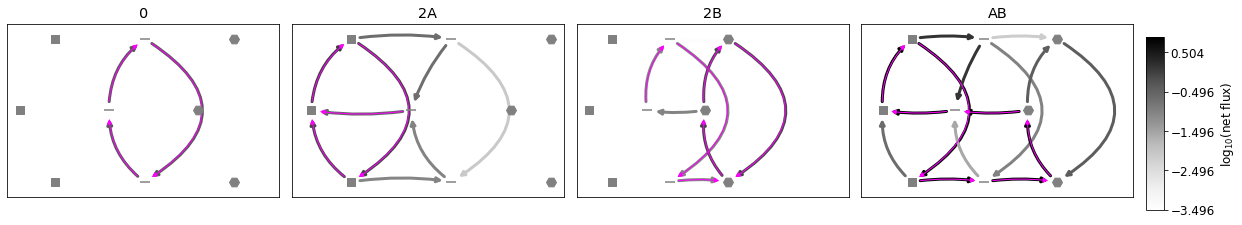

29759
[2.46379781e+02 1.07217890e+00 1.00000000e+04 1.88140711e+02]
[246.37978148   1.0721789   10.         188.14071052]
[  246.37978148  1000.         10000.           188.14071052]
[4.500564513727108, 2.435156287973725, [0.8637182824893324, 1.0563824136904083, 4.421513871410045, 23.91256032551606]]


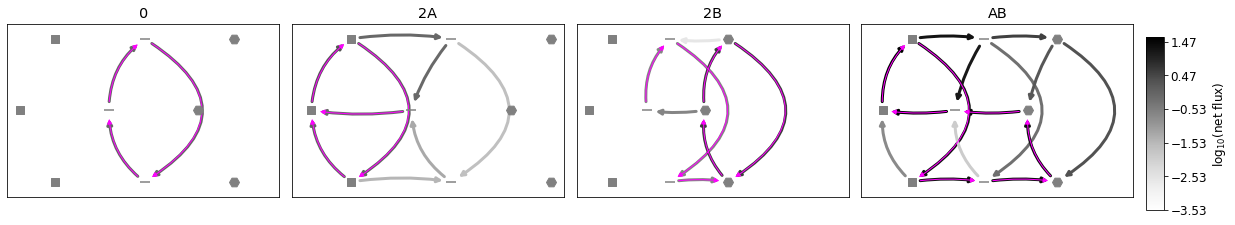

49775
[1.50478148e+02 1.00000000e+00 1.00000000e+04 1.22256191e+02]
[150.47814811   1.          10.         122.25619119]
[  150.47814811  1000.         10000.           122.25619119]
[4.033209235490895, 3.1674463076057022, [0.6416857116313293, 0.9809604531730195, 1.7876072602106121, 16.060847487220816]]


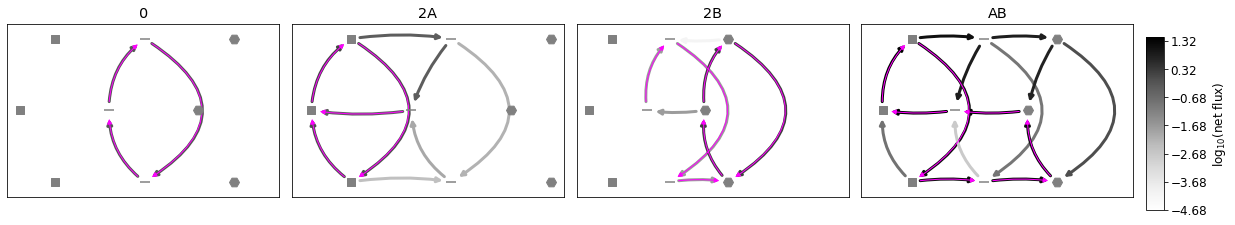

57499
[6.09567733e+02 1.00000000e+00 6.81131069e+03 8.51971283e+00]
[609.56773295   1.         697.15164824   8.51971283]
[ 609.56773295 1000.         6811.31069403    8.51971283]
[1.3515600091018183, 1.517323450683056, [0.41142746849365236, 0.783576671773771, 0.698524639448317, 1.999592971767577]]


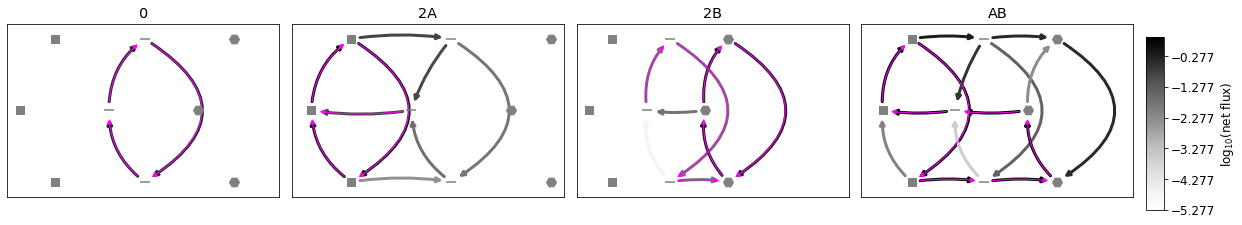

32791
[4.73168950e+01 1.00000000e+00 1.00000000e+04 4.12272111e+02]
[ 47.316895     1.         106.81531346 412.27211134]
[   47.316895    1000.         10000.           412.27211134]
[2.684414931012632, 1.7438444623411788, [0.6509633861573599, 0.9698307010838194, 1.8613834671656198, 6.234266209056805]]


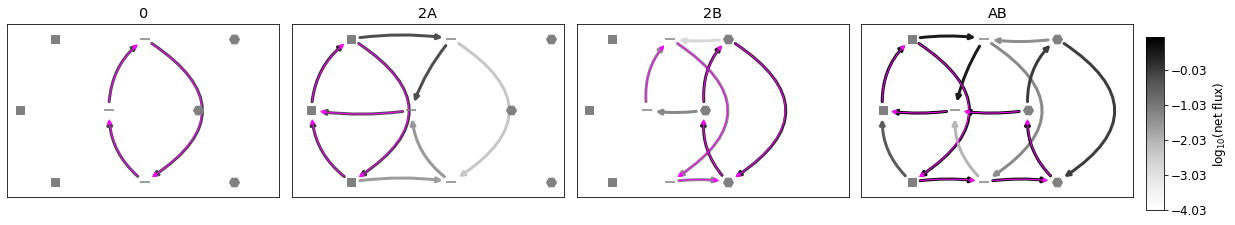

43041
[9.99183711e+01 1.00000000e+00 4.44444630e+03 4.31095737e+01]
[99.91837114  1.         16.61705506 43.10957371]
[  99.91837114 1000.         4444.44629967   43.10957371]
[2.843309918632985, 2.87951676877398, [0.48425865037505544, 0.9619132443398419, 0.9380728281168893, 6.9033116005500395]]


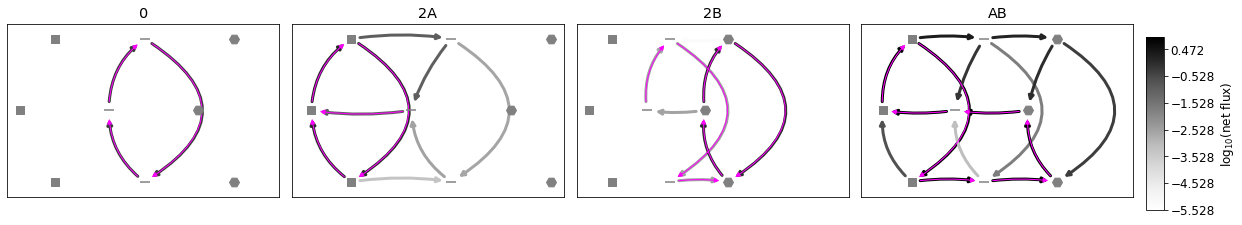

61247
[2.44303068e+02 1.00000000e+00 1.00000000e+04 3.93500849e+02]
[244.30306837   1.         183.33632848 393.50084927]
[  244.30306837   962.0432331  10000.           393.50084927]
[5.077225145366524, 1.900910161877782, [0.9003682916085506, 0.9901732003987904, 8.951117404136145, 33.427833568485966]]


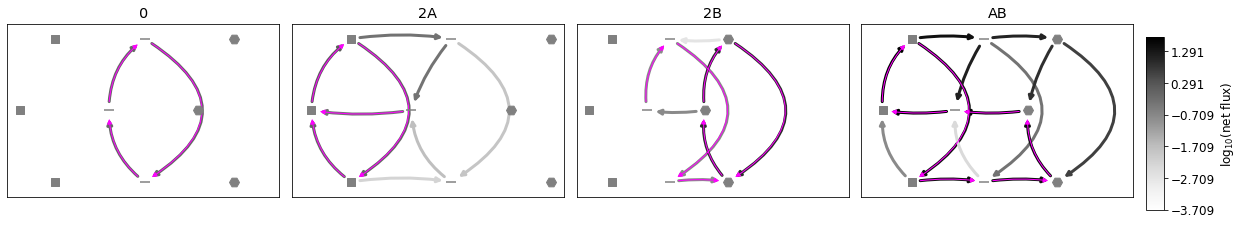

22844
[1.18555482e+02 1.00000000e+00 5.89342956e+03 4.49624015e+01]
[118.55548171   1.           5.89342956  44.96240152]
[ 118.55548171 1000.         5893.42955624   44.96240152]
[3.0730446954356756, 3.1961792505163484, [0.4681049781696799, 0.9576237503273836, 0.8792810511104622, 8.058858677944649]]


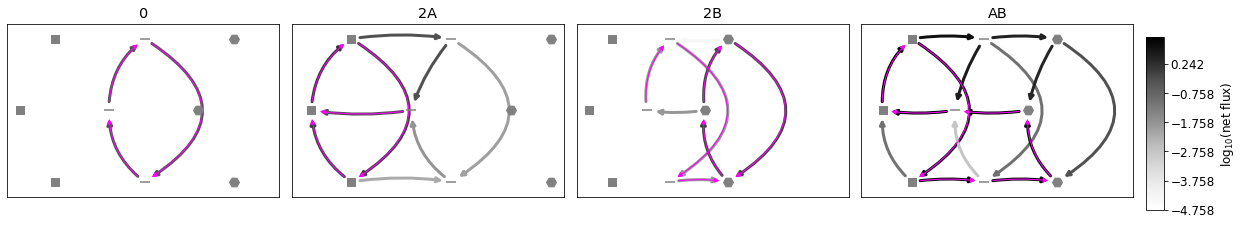

59793
[1.03755224e+02 1.00000000e+00 4.02833982e+03 3.14926169e+00]
[103.75522369   1.           6.80125009   3.14926169]
[1.03755224e+02 5.38217151e+01 4.02833982e+03 3.14926169e+00]
[0.5311356736460966, 3.7260382712088, [0.07323007525184029, 0.7225005372164008, 0.07889993751298902, 1.0440611695206259]]


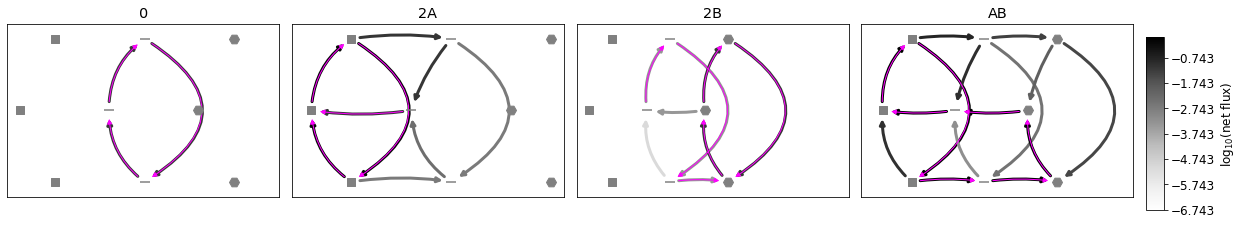

28487
[65.27501116  1.         90.05769707 25.23148621]
[65.27501116  1.          9.46660915 25.23148621]
[  65.27501116 1000.           90.05769707   25.23148621]
[3.498604730036465, 0.22870343770020474, [0.9011987522654686, 0.9336671106222456, 9.00596868366573, 10.553026466283182]]


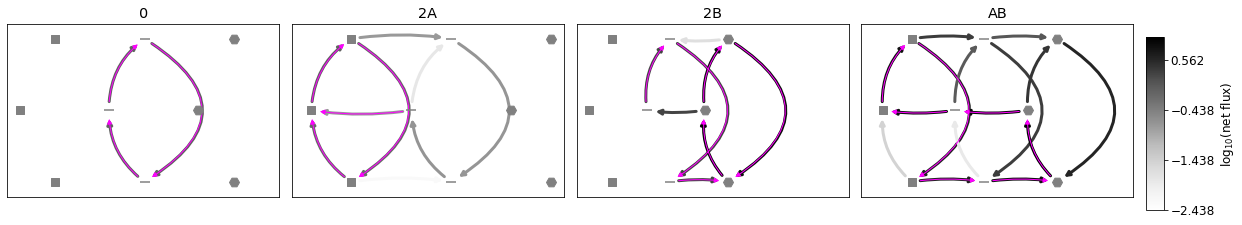

6292
[4.48234077e+02 1.00000000e+00 2.44913697e+03 2.95752699e+00]
[448.23407696   1.           2.44913697   2.95752699]
[ 448.23407696  328.06358685 2449.13697355    2.95752699]
[0.9070379427717157, 1.6117813345612984, [0.3136929930504989, 0.7439262363453472, 0.45643713978116734, 1.39500416220976]]


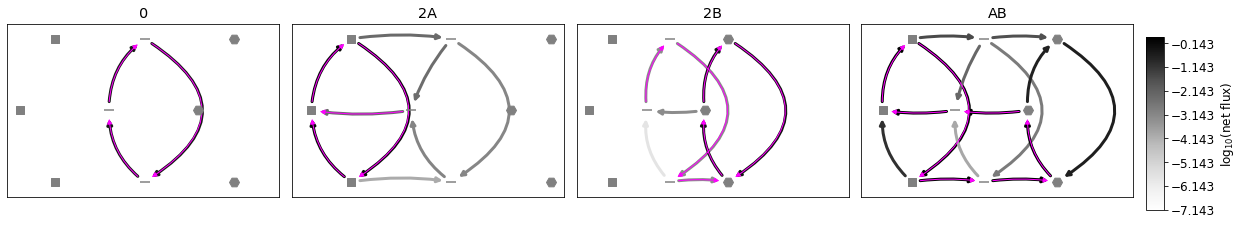

7590
[1.59185121e+02 1.65436888e+00 1.00000000e+04 9.60817816e+01]
[159.18512116   1.65436888  10.          96.08178155]
[  159.18512116  1654.36887595 10000.            96.08178155]
[2.8504521526868514, 2.9566826315680257, [0.7843338300648458, 1.6039179859710655, 1.4900594526524111, 11.567879516851956]]


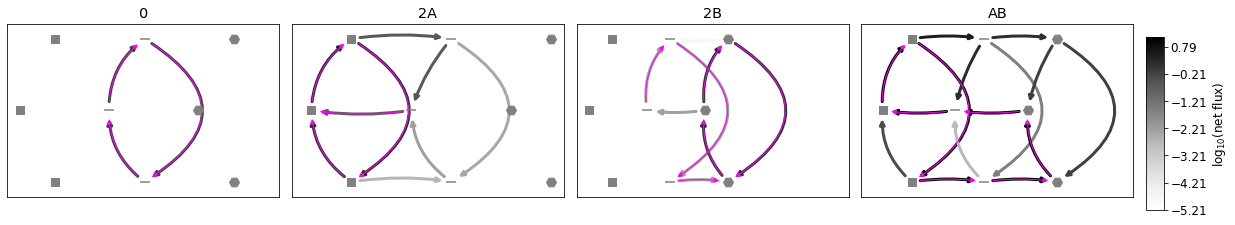

121
[344.46106188   2.34140169 106.22440391   1.        ]
[344.46106188   2.34140169   4.16753429   1.        ]
[344.46106188 624.29951206 106.22440391   1.        ]
[0.30058217117652425, 0.1643982003339342, [0.5752494664874305, 0.6930697839335114, 0.7616797775030114, 0.8536133819297588]]


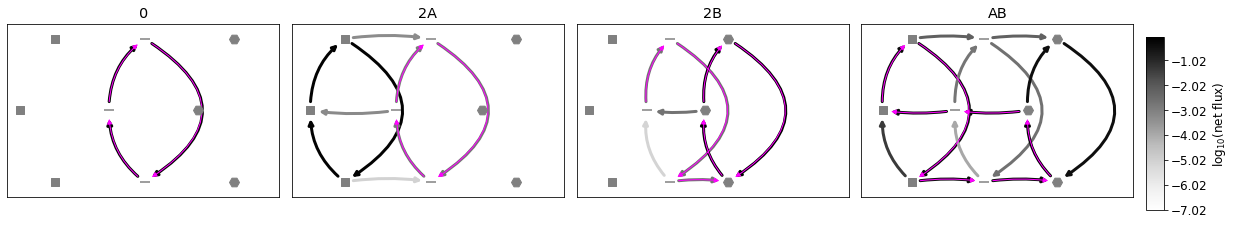

20237
[ 606.74612214    1.48889105 1022.77397309    2.09452279]
[606.74612214   1.48889105 113.34204991   2.09452279]
[ 606.74612214  266.88815542 1022.77397309    2.09452279]
[0.5783942429501882, 0.6202027741683673, [0.5113719056198448, 0.7994177813736496, 0.776583541375816, 1.1936797336307137]]


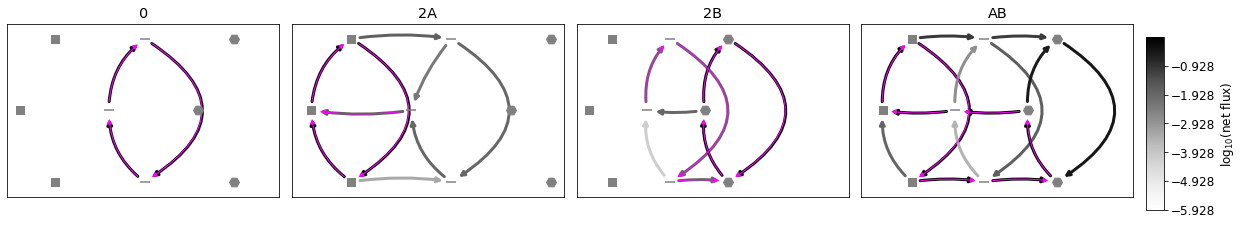

19254
[5.07971402e+02 1.00000000e+00 1.00000000e+04 1.47472475e+02]
[507.97140246   1.          10.         147.47247527]
[  507.97140246  1000.         10000.           147.47247527]
[4.55394144590759, 1.7357640024208334, [0.8754728634027401, 0.9895179120880329, 6.978781541825822, 23.24323824873472]]


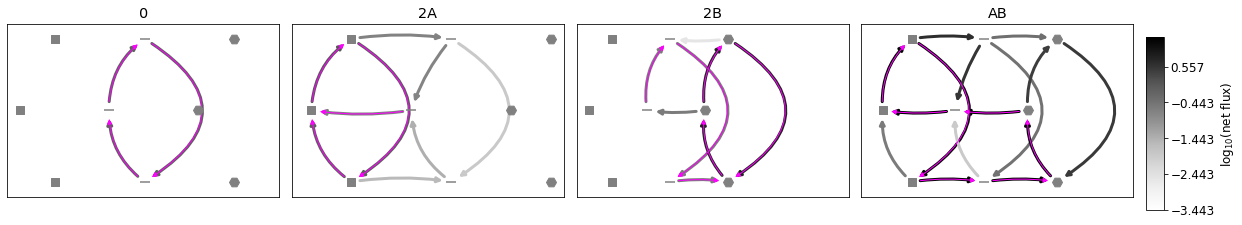

16277
[5.39659744e+02 1.00000000e+00 5.41128138e+03 7.52255265e+00]
[539.65974351   1.          93.46210904   7.52255265]
[ 539.65974351  456.63003138 5411.28137553    7.52255265]
[1.294508675379976, 1.5982261550655006, [0.4052291276747414, 0.8385857864337516, 0.6793904307013693, 2.056995956619312]]


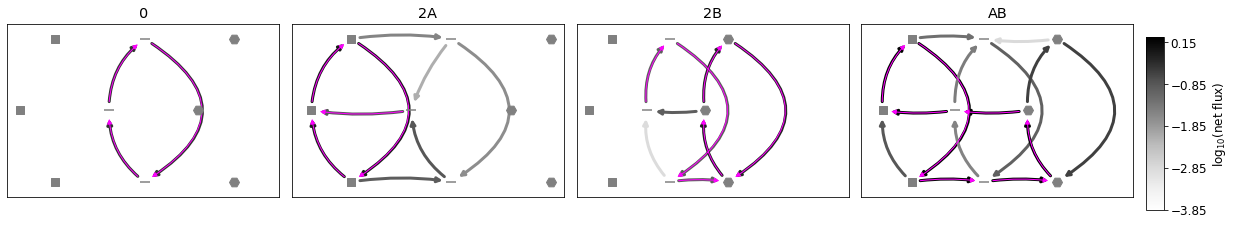

59629
[128.49683803   1.30805609 244.24420241  37.49532874]
[128.49683803   1.30805609  36.18970695  37.49532874]
[128.49683803 907.96511172 244.24420241  37.49532874]
[3.6051286700360126, 0.3774368920297303, [1.1769700837385224, 1.2369065407593676, 11.586944533598249, 15.051810916021171]]


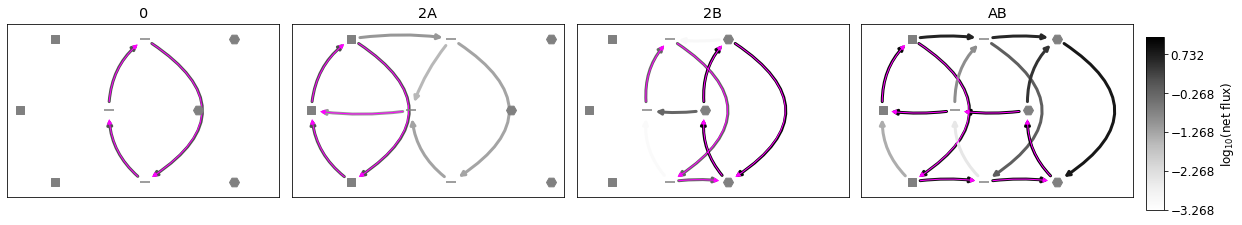

28380
[1.87052914e+02 1.00000000e+00 1.00000000e+04 8.41027460e+01]
[187.05291429   1.          10.          84.10274597]
[  187.05291429  1000.         10000.            84.10274597]
[3.4108548026648227, 2.7587226808931327, [0.6049983848085041, 0.9723906520661195, 1.5281011584275583, 10.342139265753394]]


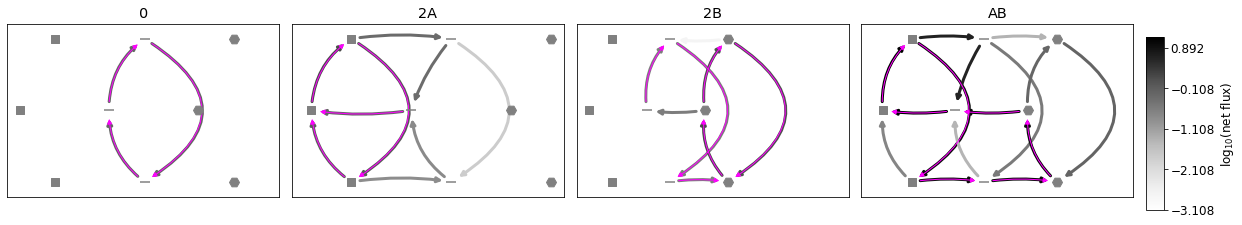

15957
[1.0000000e+04 1.0000000e+00 1.0000000e+04 3.0085445e+00]
[1.0000000e+04 1.0000000e+00 5.4301463e+02 3.0085445e+00]
[1.0000000e+04 1.0000000e+03 1.0000000e+04 3.0085445e+00]
[1.2506570943838753, 0.21628844444206236, [0.6006463143353515, 0.7325337761023516, 1.5003882154652455, 1.7430624769459717]]


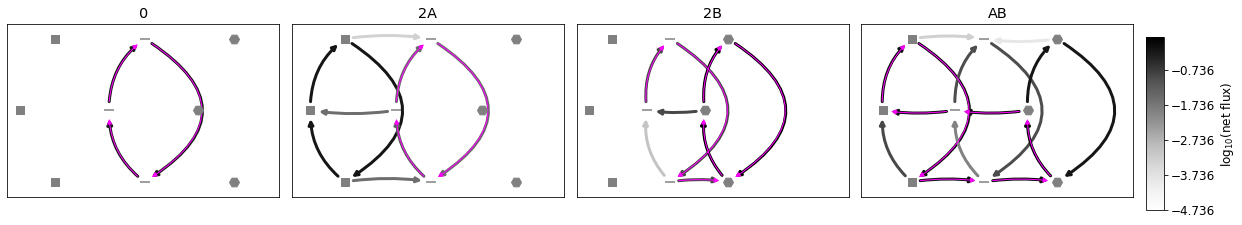

49871
[1.34658679e+03 1.00000000e+00 1.00000000e+04 6.95962554e+01]
[1.34658679e+03 1.00000000e+00 1.00000000e+01 6.95962554e+01]
[ 1346.58678871   178.70108831 10000.            69.59625542]
[4.120483399453652, 1.1260174125090343, [0.8914125922345981, 0.9841403127833248, 7.842979954096425, 17.117728024742604]]


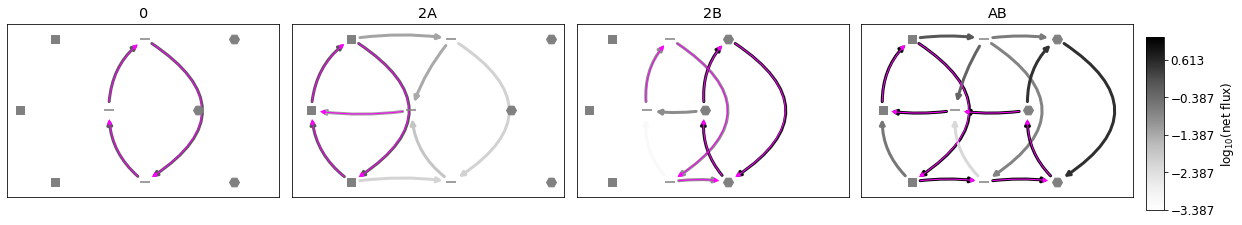

24996
[3.13945865e+02 1.00000000e+00 1.00000000e+04 2.34786685e+02]
[313.94586501   1.          10.         234.7866855 ]
[  313.94586501  1000.         10000.           234.7866855 ]
[5.047229054234204, 2.2392557055769235, [0.8748059276796577, 0.990735884386499, 6.938124654408055, 32.75859250282362]]


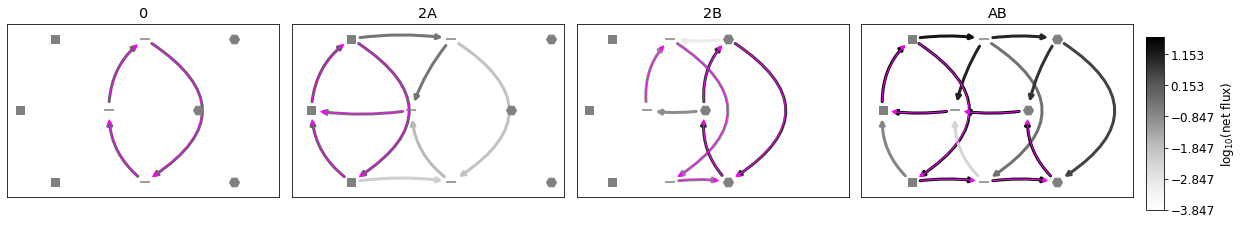

56727
[1.00000000e+04 1.00000000e+00 1.00000000e+04 1.35584077e+00]
[1.00000000e+04 1.00000000e+00 1.00000000e+01 1.35584077e+00]
[1.00000000e+04 1.00000000e+03 1.00000000e+04 1.35584077e+00]
[0.7807599965523377, 0.5270586702850885, [0.40400784421794617, 0.5681425596926931, 0.677374795245985, 0.9760891875340794]]


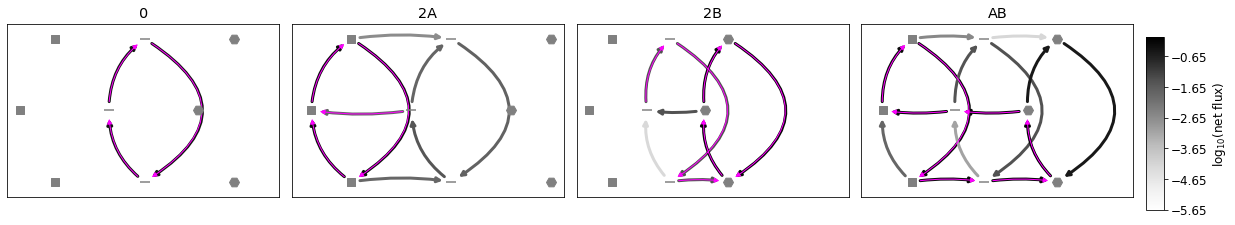

18911
[1.56917788e+02 1.00000000e+00 1.00000000e+04 1.56069199e+02]
[156.91778807   1.          10.         156.06919869]
[  156.91778807  1000.         10000.           156.06919869]
[4.244158286009538, 2.9762538577713338, [0.7036755184173359, 0.9837491387121968, 2.368981284287641, 18.642464105690497]]


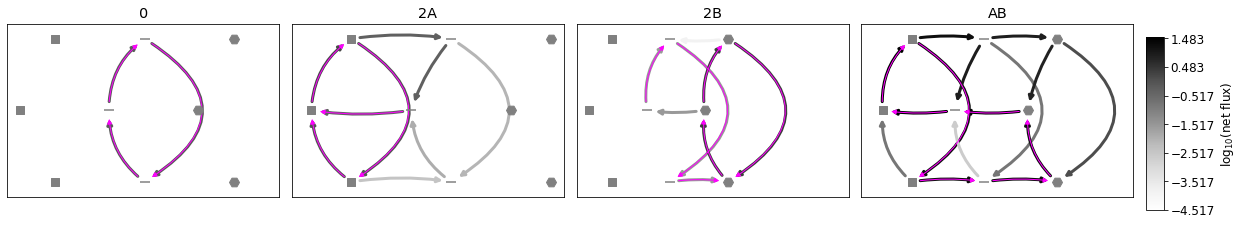

11418
[9.61087177e+01 1.00000000e+00 1.00000000e+04 1.03820023e+02]
[ 96.10871767   1.          10.         103.82002347]
[   96.10871767  1000.         10000.           103.82002347]
[1.534115367615728, 1.5363378748048235, [0.4945009391845758, 0.9787912259580323, 0.9772845348494399, 2.8346850291602532]]


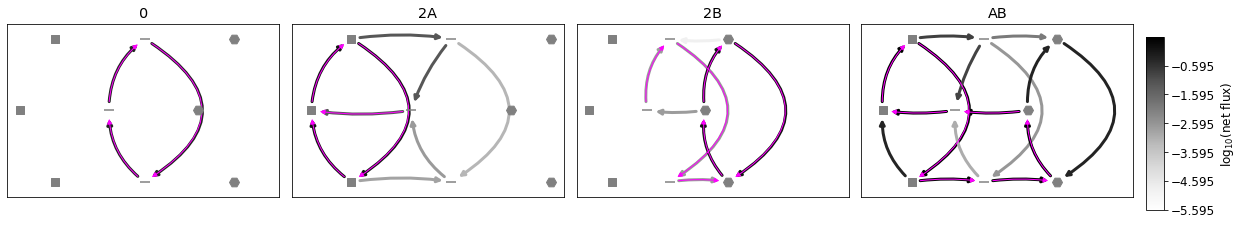

51456
[540.74433228   1.96279799 168.10319858   2.03404313]
[540.74433228   1.96279799   1.           2.03404313]
[540.74433228 485.01177774 168.10319858   2.03404313]
[0.8096895902354366, 0.14312065474747945, [0.8652067554023988, 0.9710090130897265, 1.541276316032285, 1.7020178676746023]]


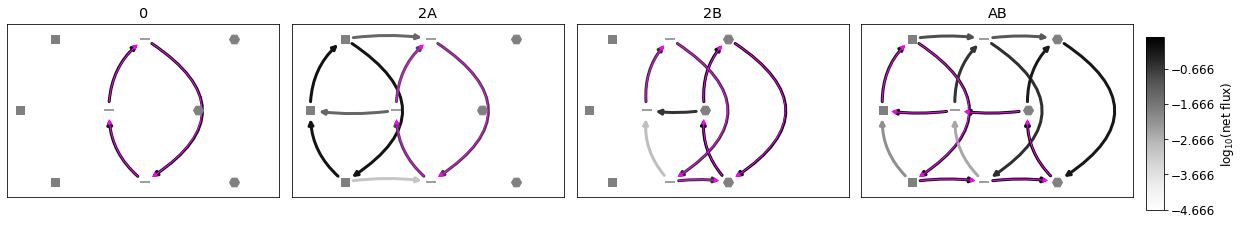

15256
[9.3741683e+03 1.0000000e+00 1.0000000e+04 1.0000000e+00]
[9.3741683e+03 1.0000000e+00 1.0000000e+01 1.0000000e+00]
[9.3741683e+03 1.0000000e+03 1.0000000e+04 1.0000000e+00]
[0.5453593346216983, 0.5541154461528215, [0.326065551686215, 0.4865163564773583, 0.48357249797310825, 0.710014084356166]]


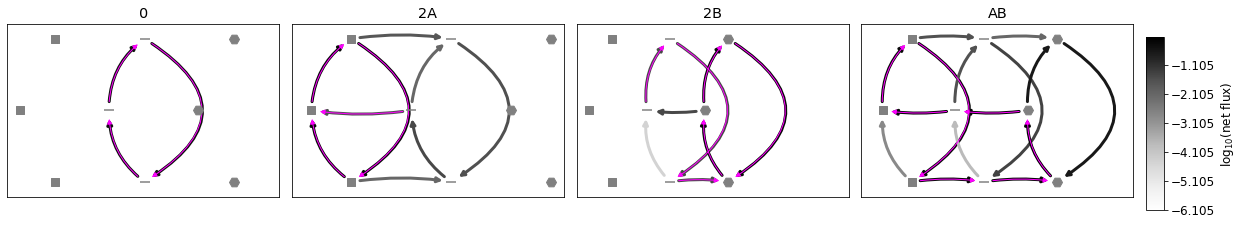

47792
[5.73948609e+01 1.38073298e+00 6.33832757e+03 4.86738791e+02]
[ 57.3948609    1.38073298 531.59953773 486.73879108]
[  57.3948609   845.54256235 6338.32756977  486.73879108]
[2.2627750421767163, 0.6388863585103259, [1.0302739712631104, 1.3107009107500742, 4.039641308987846, 6.290233429469037]]


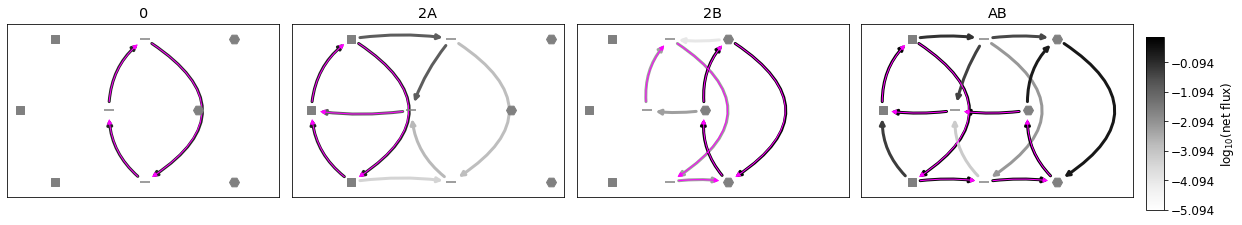

6526
[ 90.45442062   1.         356.45210603   7.04703705]
[90.45442062  1.          1.          7.04703705]
[  90.45442062 1000.          356.45210603    7.04703705]
[1.8329608728950042, 1.135534576342029, [0.5840589622075749, 0.864703100501496, 1.402210617399763, 3.080656099875172]]


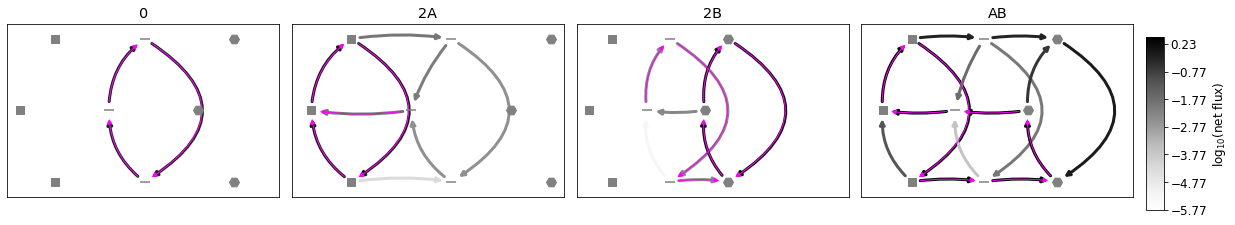

26122
[ 65.27501116   3.2456124  922.30015714  25.23148621]
[ 65.27501116   3.2456124  135.85693529  25.23148621]
[  65.27501116 1000.          922.30015714   25.23148621]
[0.711716031415125, 1.1413056497721041, [1.083360297096208, 2.1865123381397438, 1.6234262775716917, 3.580962772996214]]


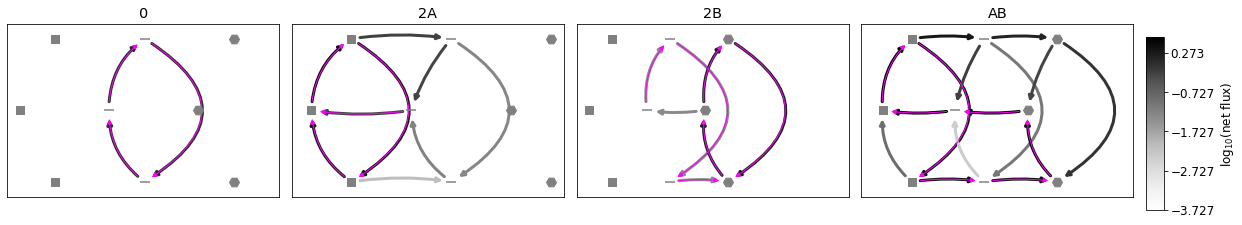

52468
[1.38962617e+03 1.00000000e+00 6.58756253e+03 8.64095811e+00]
[1.38962617e+03 1.00000000e+00 1.00000000e+01 8.64095811e+00]
[1389.62616538   22.54585501 6587.56252619    8.64095811]
[1.736351932791244, 1.0782757985218592, [0.6005793275972418, 0.8927212334115027, 1.4086935316954339, 2.974471961173569]]


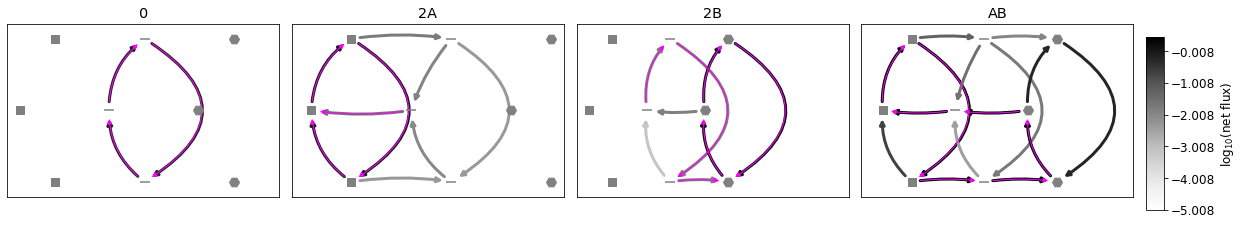

23402
[1.38569782e+02 1.00000000e+00 1.00000000e+04 8.72381138e+01]
[138.5697817    1.          10.          87.23811376]
[  138.5697817   1000.         10000.            87.23811376]
[3.634165707715022, 3.3551914520427326, [0.5417389809288816, 0.9731298389054563, 1.1807294847771728, 12.08269121178167]]


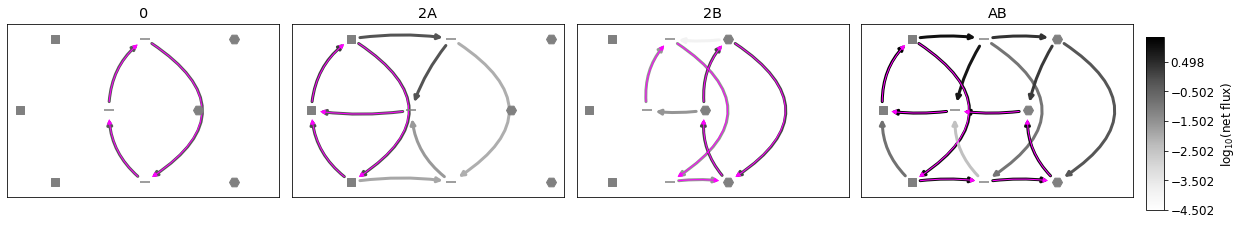

44918
[9.38347531e+02 1.00000000e+00 1.00000000e+04 6.61064498e+01]
[938.34753084   1.          33.77171655  66.10644984]
[  938.34753084  1000.         10000.            66.10644984]
[4.414633391086245, 1.8983917378914235, [0.8493268693126205, 0.9795711302394554, 5.60402664001122, 20.891664735321474]]


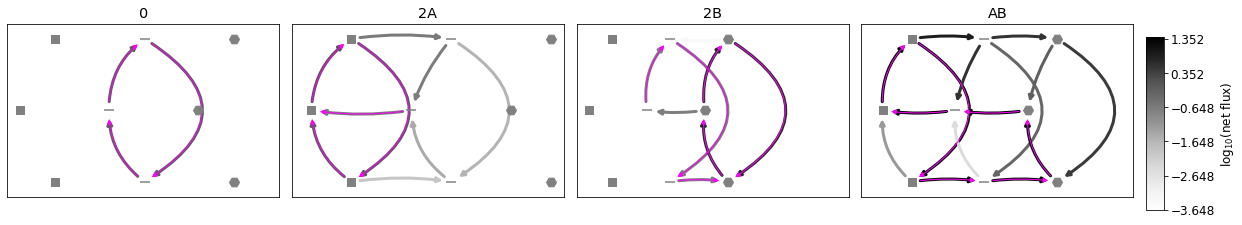

43311
[2010.45477912    3.83284744  865.37048209   43.10957371]
[2010.45477912    3.83284744    7.92972271   43.10957371]
[2010.45477912  946.13282505  865.37048209   43.10957371]
[3.1162073507761052, 0.08128075006297472, [3.39464726209298, 3.5098721738221235, 28.76704426528897, 30.4342907627379]]


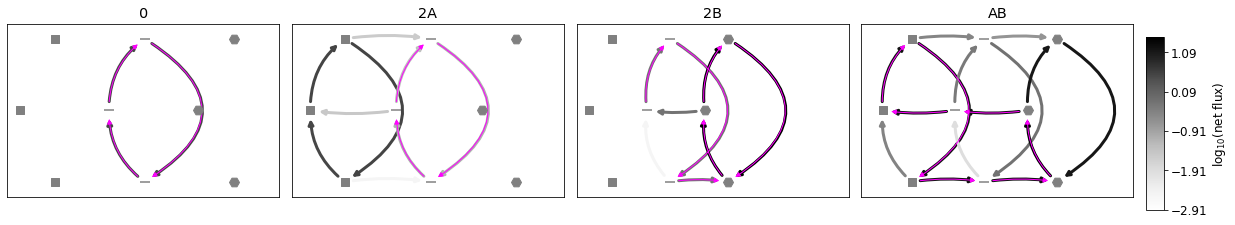

44417
[2.01045478e+03 1.00000000e+00 1.00000000e+04 3.32914889e+01]
[2.01045478e+03 1.00000000e+00 1.00000000e+01 3.32914889e+01]
[ 2010.45477912  1000.         10000.            33.29148894]
[3.964826637519702, 1.450206795921807, [0.8474988297286781, 0.9669318860605591, 5.525503801105288, 15.098285295586079]]


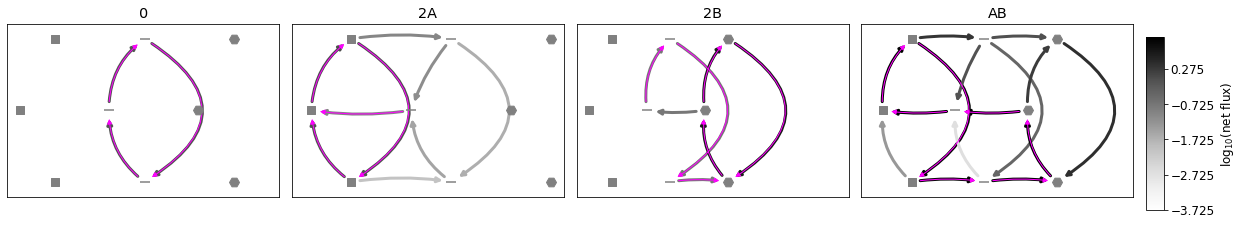

17690
[1.91324589e+02 1.00000000e+00 1.00000000e+04 5.66461160e+01]
[191.32458934   1.          10.          56.64611603]
[  191.32458934   255.20761668 10000.            56.64611603]
[3.1898839119695026, 3.071483707683257, [0.5139863117365491, 0.9700357411636248, 1.0530033411993684, 8.851940303227687]]


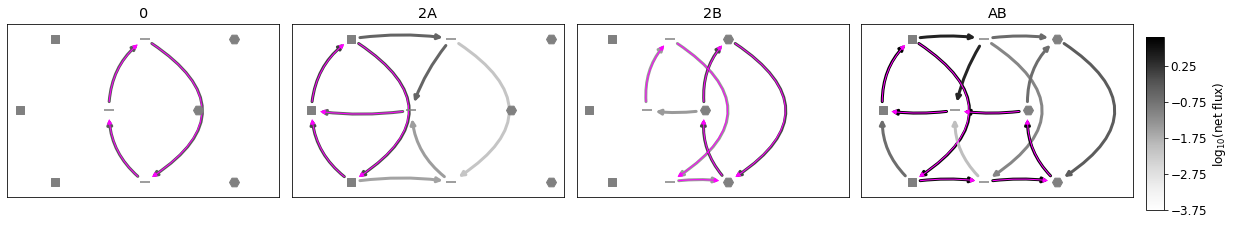

31353
[ 15.42877077   1.04361465 119.48773725   5.83734643]
[15.42877077  1.04361465  1.          5.83734643]
[  15.42877077 1000.          119.48773725    5.83734643]
[0.891485868170767, 1.1997791674865494, [0.3966609971064844, 0.7917350400940354, 0.6394025081625715, 1.4687363827604254]]


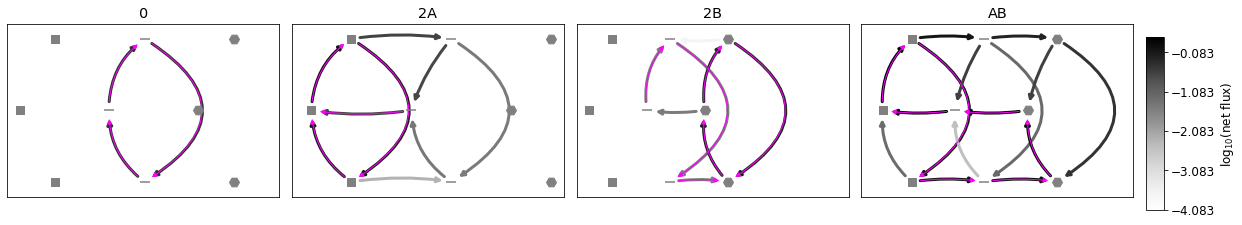

9738
[8.20420033e+02 1.00000000e+00 1.00000000e+04 9.60817816e+01]
[820.42003285   1.          10.          96.08178155]
[  820.42003285  1000.         10000.            96.08178155]
[4.810820297114087, 1.9495849340761204, [0.8783594276780889, 0.9864506927809524, 7.167918374085037, 27.687044283434748]]


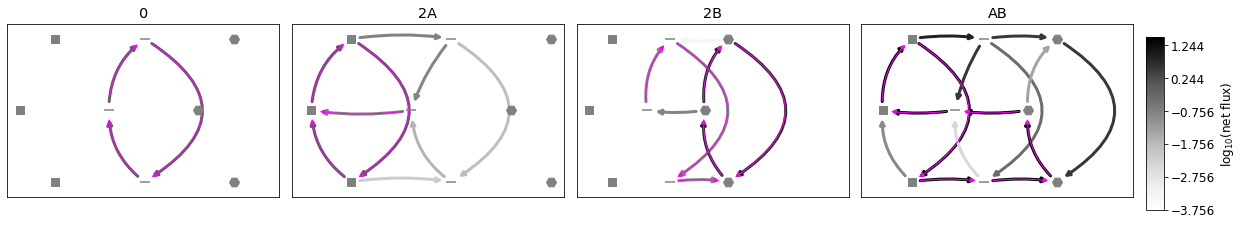

18657
[1.33334357e+02 1.00000000e+00 1.00000000e+04 2.86514187e+02]
[133.3343575    1.          10.         286.51418691]
[  133.3343575   1000.         10000.           286.51418691]
[4.021360052354567, 2.135050051492542, [0.7856969818164348, 0.9880840873120568, 3.652832823206624, 16.045154538222402]]


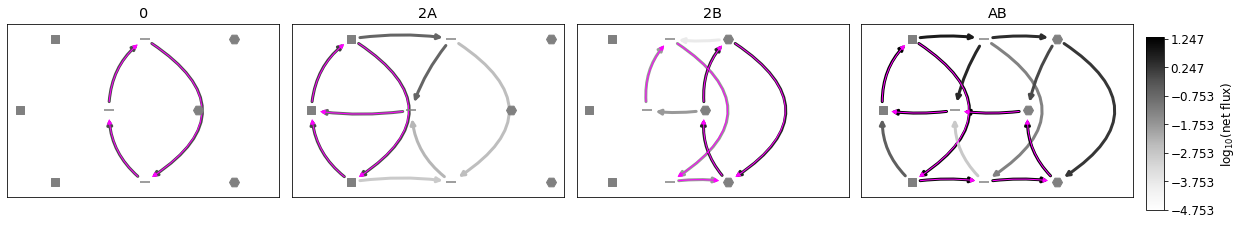

38528
[9.15228066e+01 1.00000000e+00 1.00000000e+04 1.31470199e+02]
[ 91.52280656   1.          58.2677194  131.47019879]
[   91.52280656  1000.         10000.           131.47019879]
[3.505880316633819, 3.2347093357108614, [0.5406534874905665, 0.9741684950763209, 1.175613810917244, 11.066472693951013]]


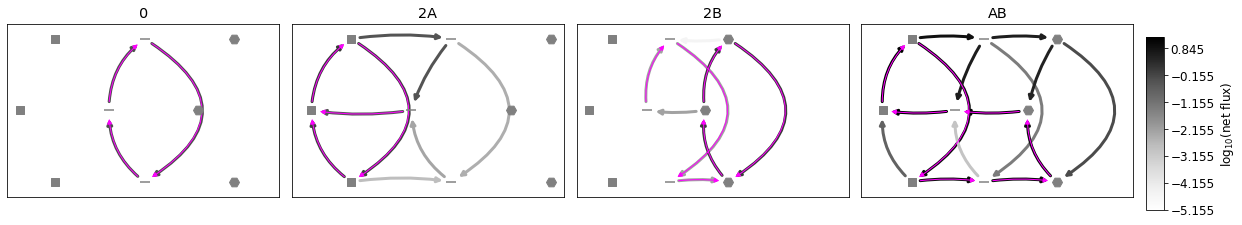

15677
[5.70199111e+03 1.00000000e+00 1.00000000e+04 2.15549107e+00]
[5.70199111e+03 1.00000000e+00 6.32611642e+01 2.15549107e+00]
[5.70199111e+03 1.00000000e+03 1.00000000e+04 2.15549107e+00]
[0.9589835502311284, 0.638705242777179, [0.439032190412642, 0.6260340249543733, 0.7816481696656234, 1.216972464036066]]


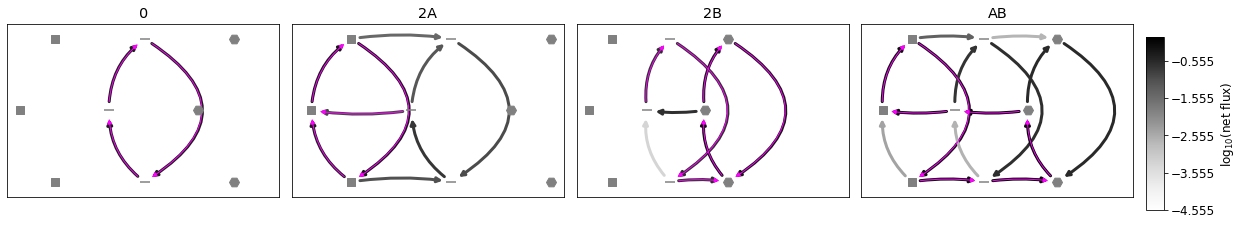

48732
[1.12108013e+02 1.38073298e+00 7.45222849e+03 4.86738791e+02]
[112.10801307   1.38073298 531.59953773 486.73879108]
[ 112.10801307  130.2410499  7452.22849272  486.73879108]
[3.1783111619911466, 0.9147640202085668, [1.1470561545079323, 1.3400288263077245, 6.434424764024977, 12.130567986255834]]


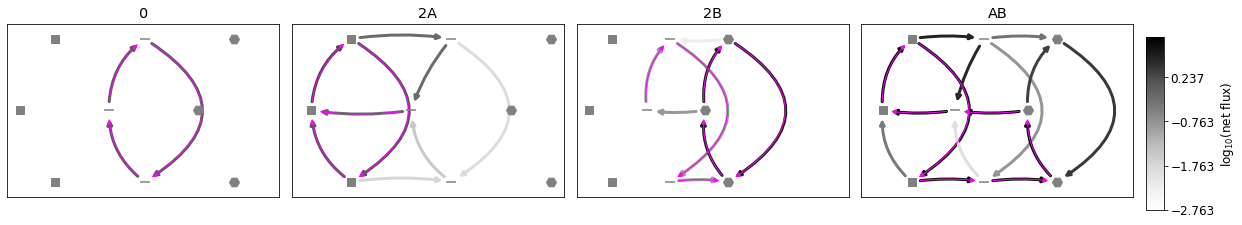

15444
[3.28891573e+03 1.00000000e+00 1.00000000e+04 2.80000867e+00]
[3.28891573e+03 1.00000000e+00 8.69715525e+01 2.80000867e+00]
[3.28891573e+03 1.00000000e+03 1.00000000e+04 2.80000867e+00]
[0.7600336813376083, 0.6962969376758595, [0.409275674568242, 0.6575197531061446, 0.6872195029060906, 1.113529533752127]]


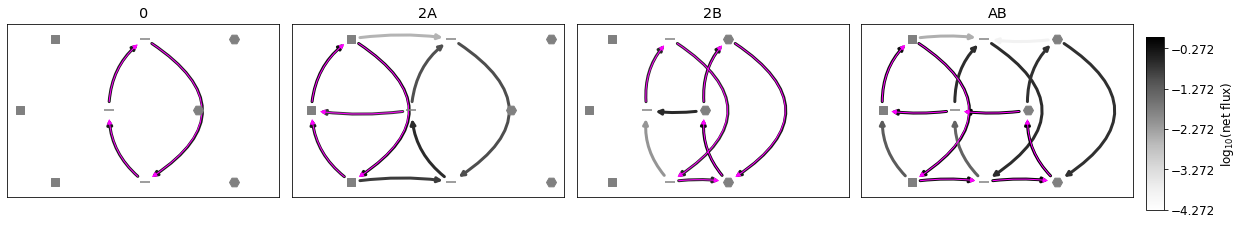

53738
[2.39489598e+02 1.57563466e+00 1.00000000e+04 6.69785512e+01]
[239.48959769   1.57563466  11.40588134  66.97855119]
[  239.48959769   313.29273202 10000.            66.97855119]
[3.0077551285034887, 2.9825301417420977, [0.7829712572704263, 1.521784541738791, 1.5486263547820731, 12.239894698286204]]


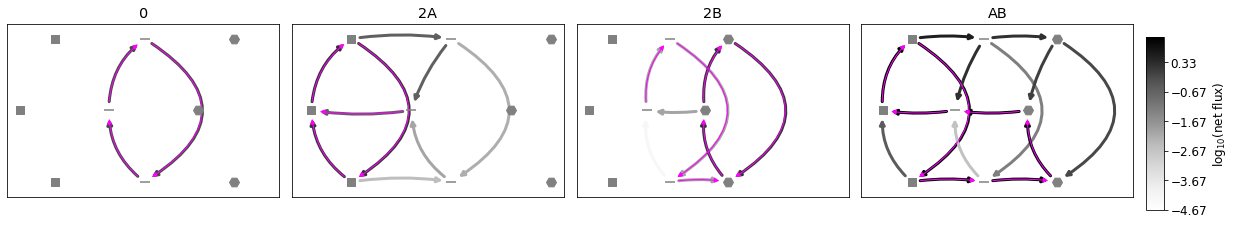

60000
[5.14619731e+02 1.00000000e+00 2.88591148e+03 4.00329194e+01]
[514.61973131   1.          20.8745286   40.03291941]
[ 514.61973131 1000.         2885.91148345   40.03291941]
[3.8795891424885407, 1.2578368594662965, [0.8568953494070434, 0.9666113414737225, 5.949465697772522, 14.227368795738155]]


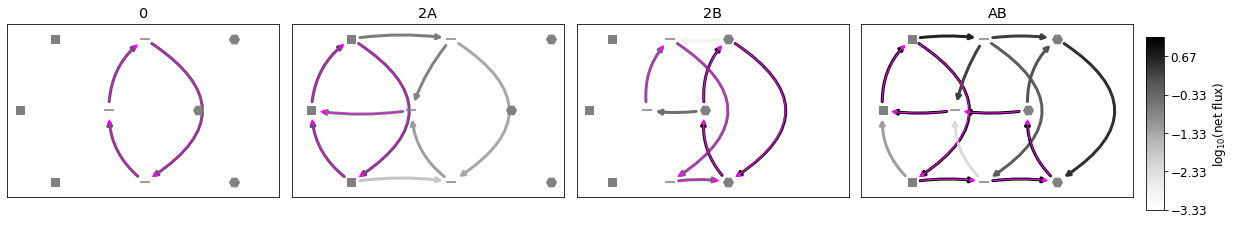

13911
[1.45195211e+02 1.00000000e+00 1.00000000e+04 2.33893688e+01]
[145.19521142   1.          10.          23.38936883]
[  145.19521142  1000.         10000.            23.38936883]
[2.568251606313598, 4.064087589851549, [0.2503591787741372, 0.9415774233721815, 0.33386011377432234, 5.584403705538131]]


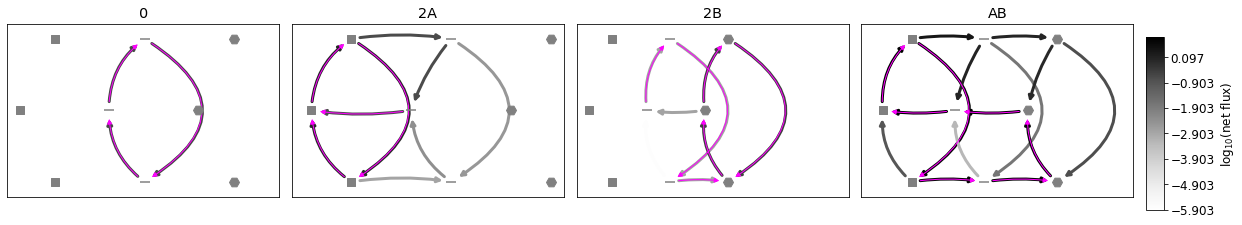

20107
[1.0106954e+03 1.0000000e+00 7.6319446e+02 1.0000000e+00]
[1.01069540e+03 1.00000000e+00 5.25588471e+01 1.00000000e+00]
[1.01069540e+03 1.37892613e+02 7.63194460e+02 1.00000000e+00]
[0.4753972729305839, 0.2555447912959741, [0.36283053868856674, 0.4869396234761262, 0.567096944318031, 0.6769926514941397]]


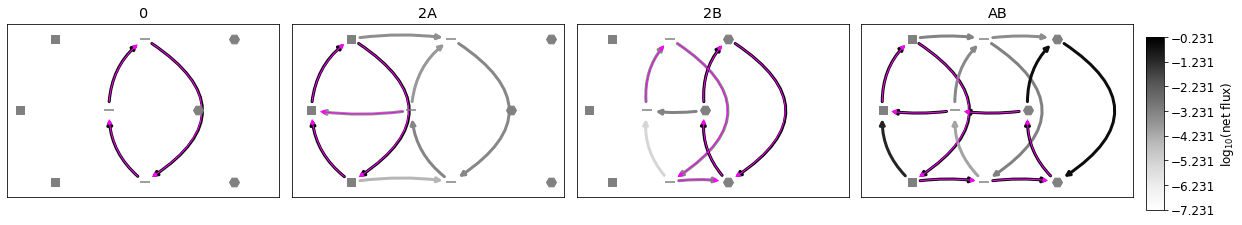

42081
[7.48737158e+01 1.00000000e+00 2.95213562e+03 8.11709496e+01]
[74.87371581  1.         14.11456121 81.17094961]
[  74.87371581  277.2516213  2952.13561948   81.17094961]
[2.038851305776584, 1.0306032462470942, [0.6616302445710482, 0.9433738016410217, 1.8975652576902564, 3.8764948474996266]]


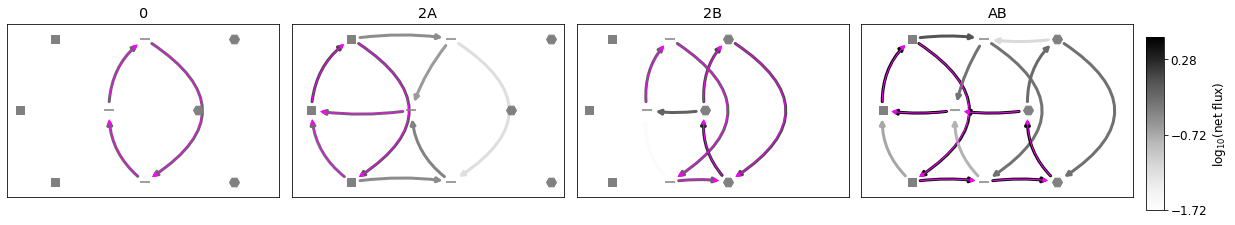

20327
[392.23422655   1.         176.9724209    1.        ]
[392.23422655   1.           1.           1.        ]
[ 392.23422655 1000.          176.9724209     1.        ]
[0.7170317085507849, 0.19209320959529746, [0.4075411146255171, 0.47765646388440025, 0.6872866264369744, 0.7851700248207676]]


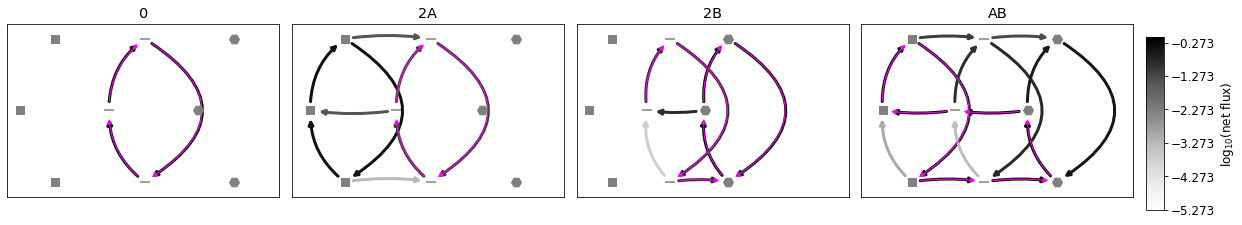

28303
[2.86800379e+02 1.00000000e+00 1.00000000e+04 7.51987501e+00]
[286.80037874   1.          88.57968078   7.51987501]
[2.86800379e+02 1.00000000e+03 1.00000000e+04 7.51987501e+00]
[1.3678382643735976, 3.3508046966600267, [0.1732149203763926, 0.8279925965693322, 0.20945661326330897, 2.136912799565131]]


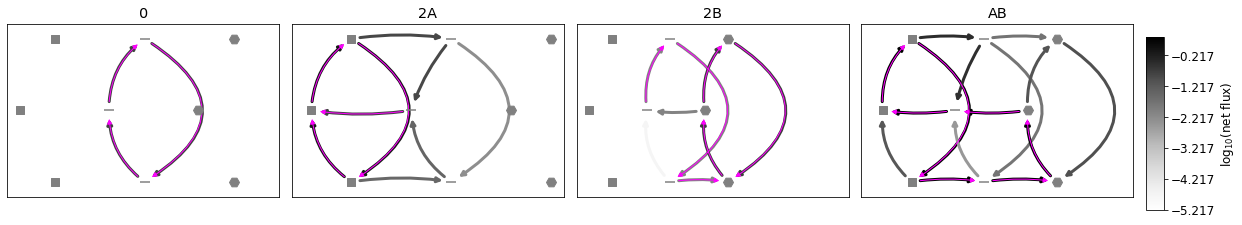

12845
[6.19904404e+01 1.00000000e+00 2.41689225e+03 9.74903045e+01]
[61.99044035  1.          2.41689225 97.49030453]
[  61.99044035 1000.         2416.89225012   97.49030453]
[3.096356416361443, 1.8168916273479785, [0.7011112707403282, 0.9634864527342734, 2.3388528156386577, 8.240276245593297]]


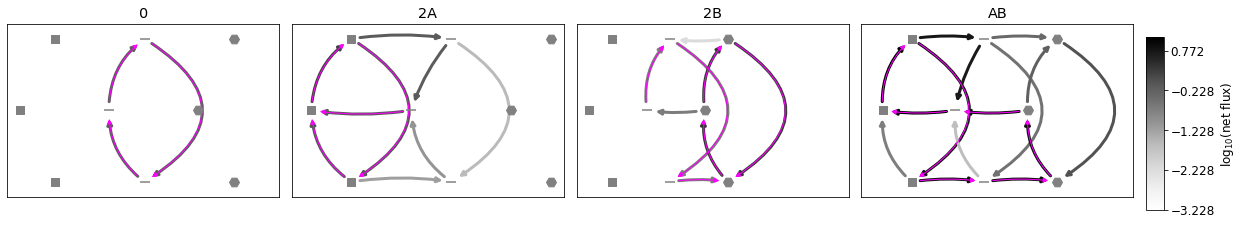

44115
[5.28008983e+02 1.00000000e+00 6.60764654e+03 4.31095737e+01]
[528.00898282   1.          56.78062624  43.10957371]
[ 528.00898282 1000.         6607.64654194   43.10957371]
[3.7379082442579463, 2.0332965183938665, [0.7602363529138071, 0.9696611007055242, 3.1605250298481646, 12.937265062634964]]


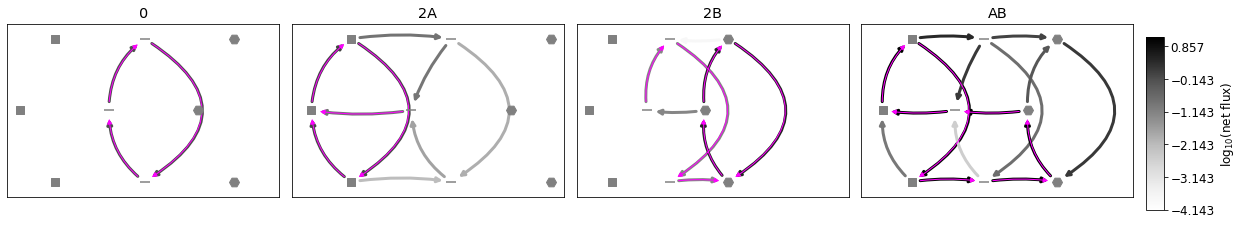

42645
[1.01149383e+02 1.00000000e+00 1.00000000e+04 9.86583661e+01]
[101.14938345   1.          10.          98.6583661 ]
[  101.14938345  1000.         10000.            98.6583661 ]
[2.5556740313541915, 2.555014237598465, [0.4945345556843638, 0.9769473182245042, 0.9773942118087521, 5.743884358034919]]


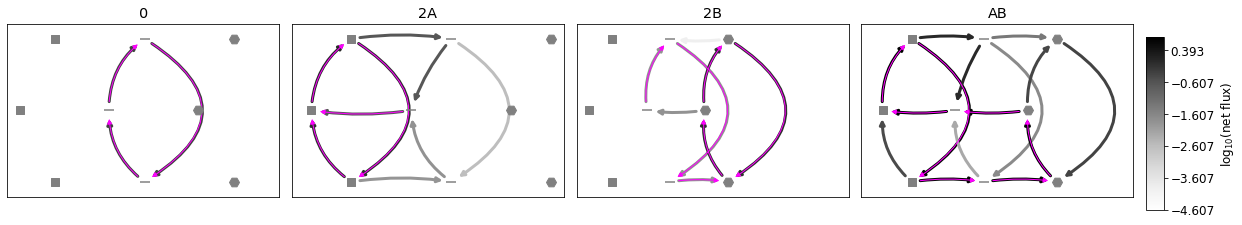

52623
[4.10781682e+02 1.00000000e+00 1.00000000e+04 2.24808921e+01]
[410.78168156   1.         462.14735368  22.48089208]
[  410.78168156   926.44154563 10000.            22.48089208]
[1.86394904167535, 1.889690907555674, [0.46953112044159656, 0.8997633675284478, 0.8838513585190618, 3.2751627016542373]]


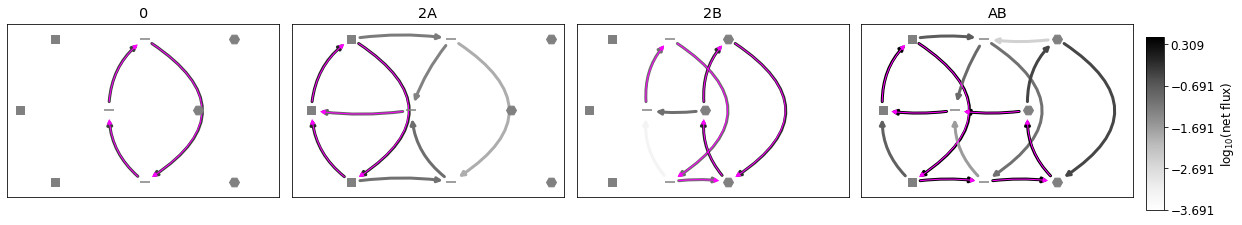

39089
[3.43478508e+01 1.00000000e+00 3.05536877e+03 1.51976766e+01]
[34.34785083  1.          4.1965773  15.19767663]
[  34.34785083 1000.         3055.36876997   15.19767663]
[1.5401657949332153, 3.950853984921112, [0.1439257736725915, 0.8938061887617341, 0.16809465417936634, 2.599437979544206]]


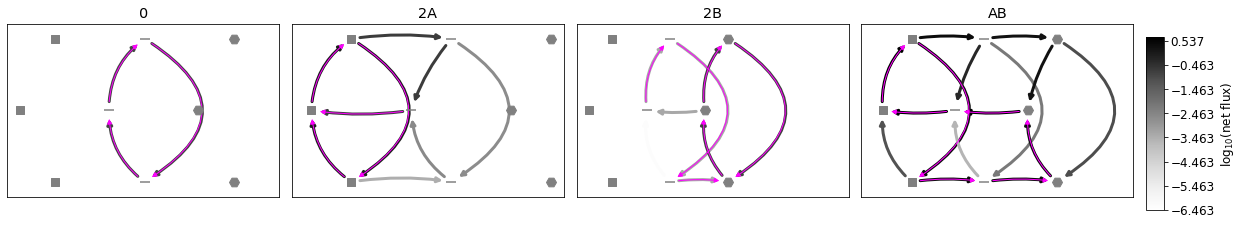

51892
[2.04759603e+02 1.00000000e+00 1.00000000e+04 4.87806027e+01]
[204.75960325   1.          10.          48.78060275]
[  204.75960325  1000.         10000.            48.78060275]
[1.1800909464062805, 1.180431827475656, [0.49344814059914455, 0.9733562488403696, 0.9731262906622054, 2.205538249010438]]


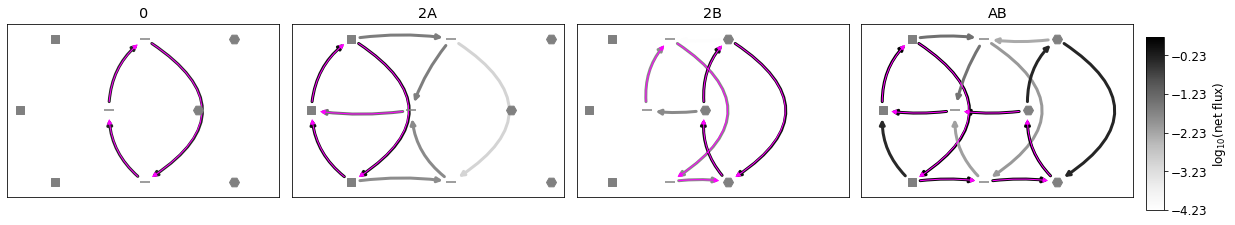

18484
[9.85260593e+02 1.00000000e+00 1.00000000e+04 1.02381222e+02]
[9.85260593e+02 1.00000000e+00 3.34153572e+03 1.02381222e+02]
[  985.26059297  1000.         10000.           102.38122154]
[3.8825744553474633, 0.6442369150051511, [0.9009676745344646, 0.9547102159061162, 9.00965799391362, 14.081306162469218]]


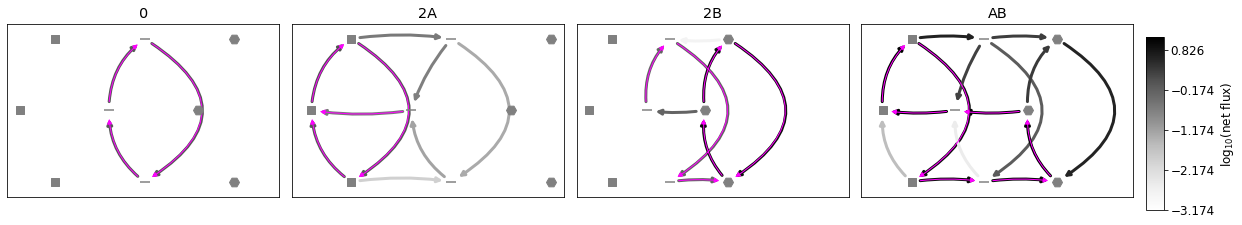

55237
[5.58419807e+01 1.00000000e+00 1.00000000e+04 6.32367237e+01]
[55.84198073  1.         10.         63.23672373]
[   55.84198073  1000.         10000.            63.23672373]
[2.7949686808452134, 4.25260651265591, [0.2586941594292415, 0.9581417888737048, 0.3488486702994388, 6.649656199484284]]


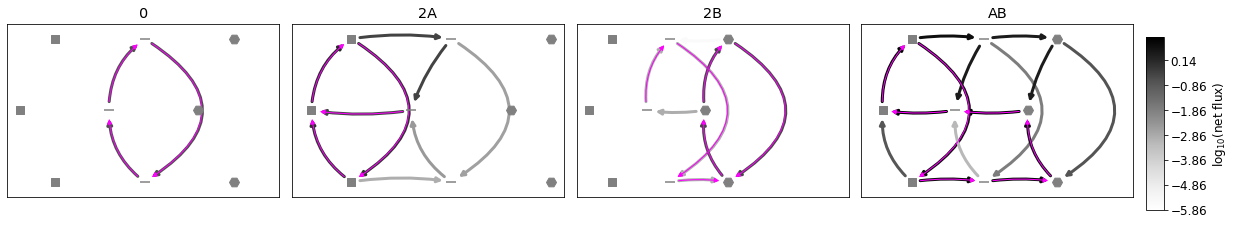

7813
[1.01077076e+02 1.00000000e+00 1.00000000e+04 8.13700951e+01]
[101.07707612   1.          10.          81.37009505]
[  101.07707612  1000.         10000.            81.37009505]
[2.9563713027167724, 3.206084408550511, [0.4468195412841731, 0.9588879676621493, 0.8064858163663862, 7.442593674084009]]


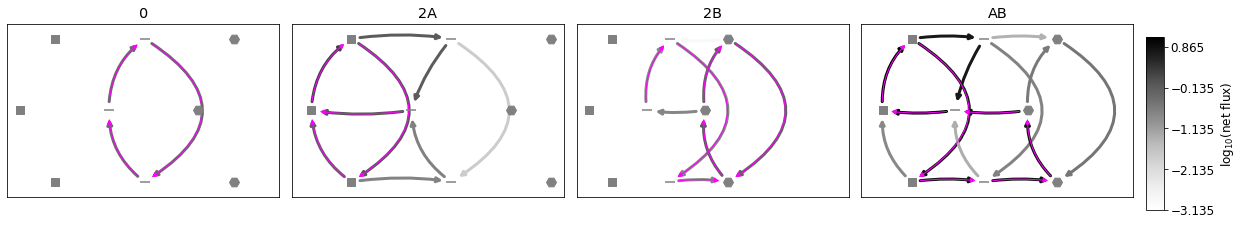

50711
[3.38301108e+02 1.00000000e+00 1.00000000e+04 2.37495075e+02]
[338.30110839   1.          10.         237.49507503]
[  338.30110839  1000.         10000.           237.49507503]
[4.971949575661592, 2.0443912019706754, [0.8836810233721369, 0.9906945048074067, 7.537418661761729, 31.091789106537046]]


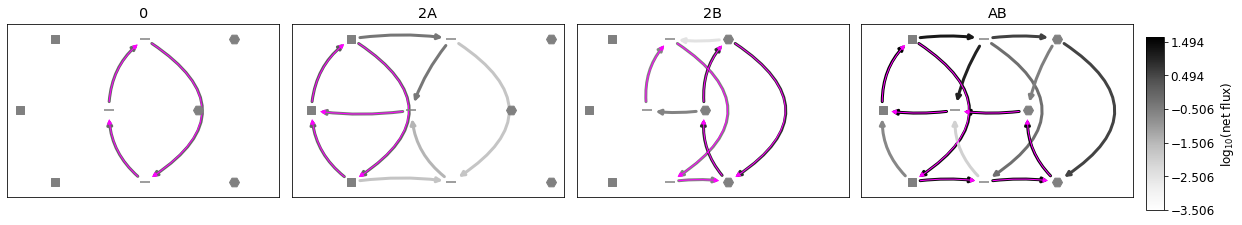

212
[1.e+04 1.e+00 1.e+04 1.e+00]
[1.e+04 1.e+00 1.e+01 1.e+00]
[1.e+04 1.e+03 1.e+04 1.e+00]
[0.4397886399741364, 0.43951648507260377, [0.33332222259258026, 0.4996307580714319, 0.499725019008287, 0.6777019554721708]]


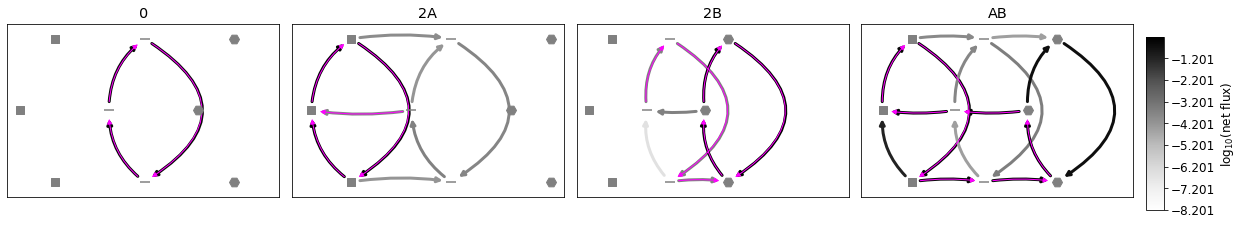

13828
[1.02473092e+03 1.00000000e+00 1.00000000e+04 4.74147012e+01]
[1.02473092e+03 1.00000000e+00 1.00000000e+01 4.74147012e+01]
[ 1024.73091796  1000.         10000.            47.4147012 ]
[4.000193769570877, 1.8394668924837552, [0.8144108850629342, 0.9770771170889441, 4.368903425749613, 15.635333727080686]]


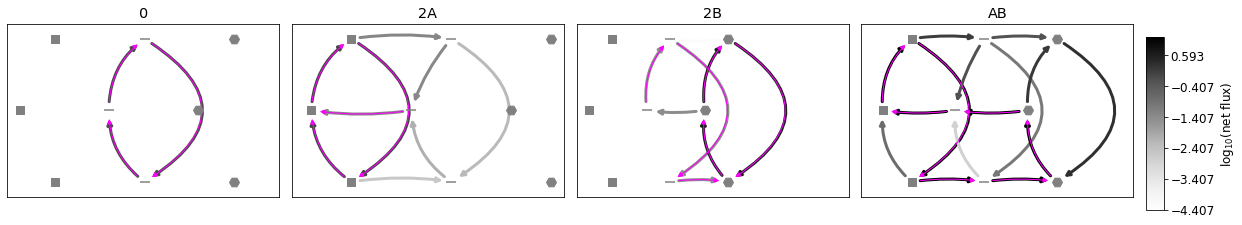

56561
[1.00000000e+04 1.00000000e+00 7.45720985e+03 1.00000000e+00]
[1.00000000e+04 1.00000000e+00 7.45720985e+00 1.00000000e+00]
[1.00000000e+04 4.17757871e+02 7.45720985e+03 1.00000000e+00]
[0.6254508796156968, 0.3965564569027552, [0.364189801695671, 0.4879909307341749, 0.5718943919460353, 0.7528201351342357]]


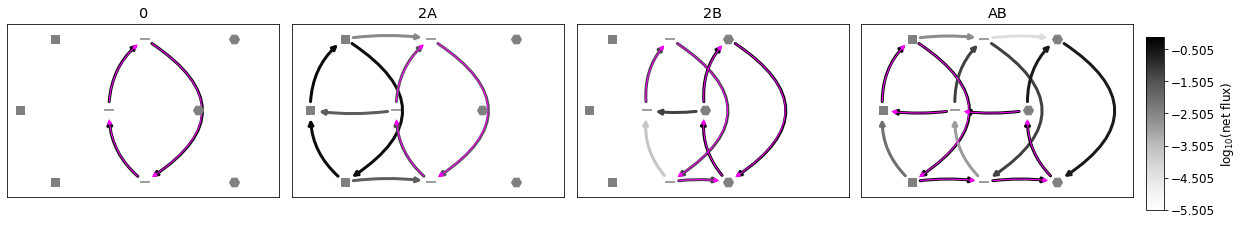

56902
[1.15388432e+03 2.99412239e+00 3.02180738e+03 7.18679513e+00]
[1153.88432294    2.99412239    3.02180738    7.18679513]
[1153.88432294  483.47102723 3021.80737564    7.18679513]
[0.905975656859855, 0.9175460270529053, [1.192761264014765, 1.9891149843623868, 1.9732261420799182, 3.7272260868600413]]


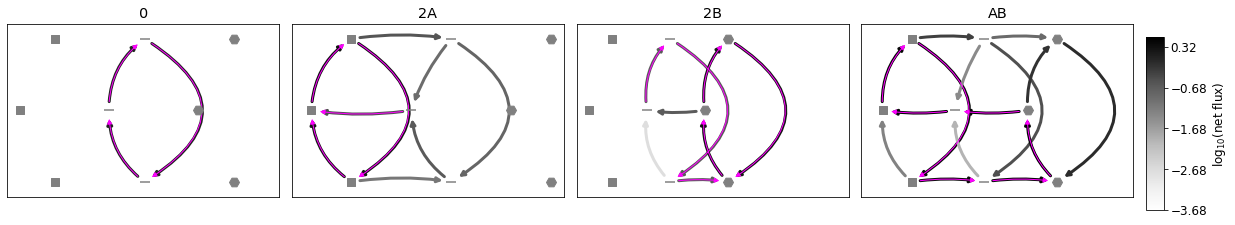

42378
[1.07813060e+02 1.00000000e+00 2.95213562e+03 2.70711361e+01]
[107.81305975   1.           7.93371753  27.07113614]
[ 107.81305975   30.29782258 2952.13561948   27.07113614]
[2.2585811263337106, 2.307946874826617, [0.48598003330208195, 0.9485876173064265, 0.9166781510415072, 4.539187451110998]]


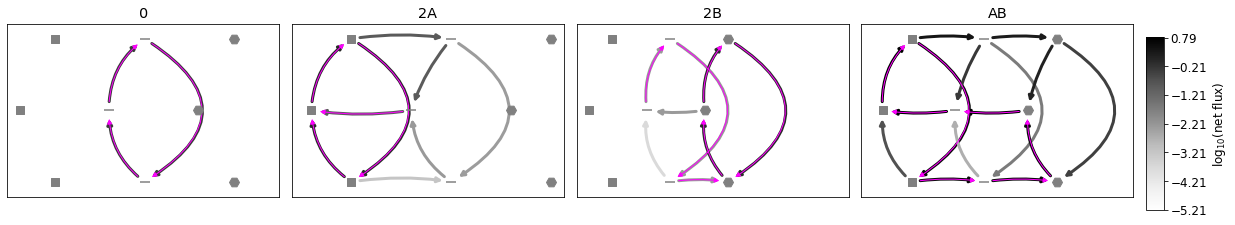

22039
[1.97362919e+02 1.00000000e+00 3.40752480e+03 1.77987076e+01]
[197.36291908   1.           3.4075248   17.79870758]
[ 197.36291908   64.55639804 3407.52479848   17.79870758]
[2.3830003559802786, 2.356083232395942, [0.49230035208803063, 0.9375884319412109, 0.9552457231587641, 4.890652742923833]]


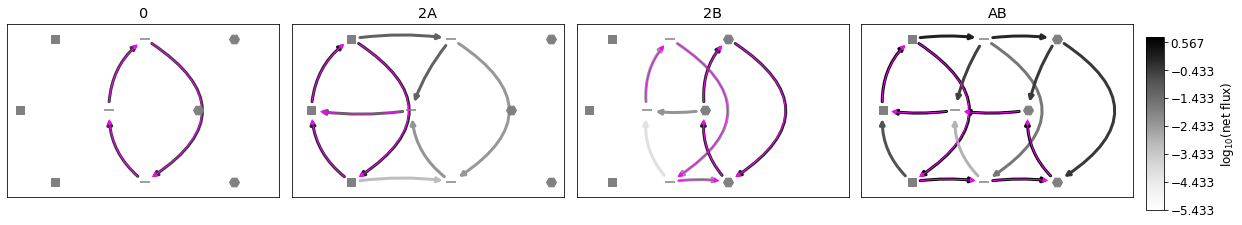

58191
[9.68012545e+01 1.00000000e+00 1.00000000e+04 1.02700549e+02]
[ 96.80125446   1.          10.         102.70054865]
[   96.80125446  1000.         10000.           102.70054865]
[2.212430757495011, 2.2198562274635876, [0.49359616455392585, 0.9787833587972192, 0.9737585583540943, 4.536225109668994]]


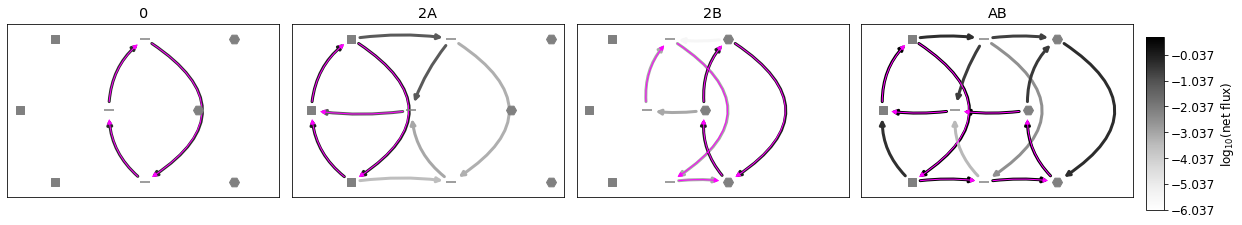

39353
[5.13616004e+01 1.00000000e+00 1.00000000e+04 2.02036139e+01]
[51.36160044  1.         32.22810126 20.20361395]
[   51.36160044  1000.         10000.            20.20361395]
[1.0684975608568366, 4.205640529163845, [0.09340769761763393, 0.9063584883993817, 0.1030210263633324, 1.9008586461275672]]


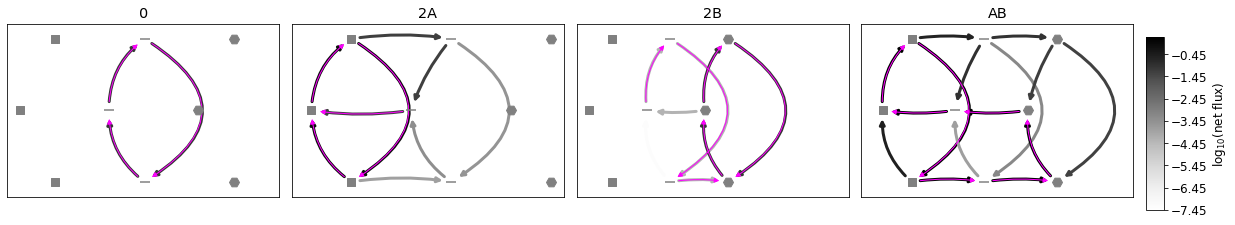

51170
[7.89475759e+01 1.00000000e+00 1.27046328e+03 1.87051709e+01]
[78.94757585  1.         73.21045378 18.7051709 ]
[  78.94757585    4.51665974 1270.46327503   18.7051709 ]
[0.4808746525581787, 0.5218230391019802, [0.5190892505469022, 0.8905119440608753, 0.8655916458093316, 1.2427891224433119]]


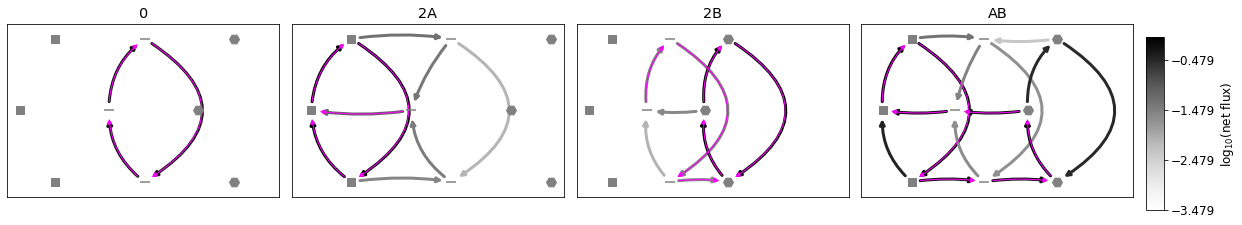

18205
[4.34098162e+03 1.00000000e+00 1.00000000e+04 2.25622528e+01]
[4.34098162e+03 1.00000000e+00 1.00000000e+01 2.25622528e+01]
[ 4340.98162192   269.87072887 10000.            22.56225277]
[3.630099621308263, 0.831563262944807, [0.8721033542742127, 0.9549274959168047, 6.643757716697036, 11.82331531050387]]


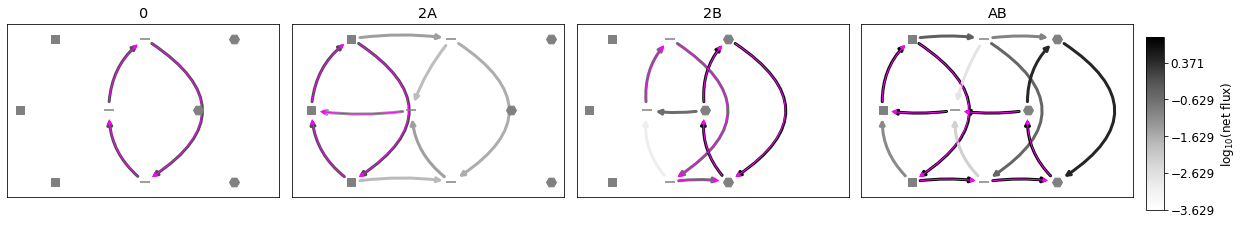

46807
[1.08975948e+03 8.36741983e+00 1.00000000e+04 7.85453627e+01]
[1089.75947554    8.36741983   10.           78.54536274]
[ 1089.75947554   178.70108831 10000.            78.54536274]
[1.3180208422140618, 1.3324992160762308, [4.000179482797942, 7.41051521692396, 7.336517850849531, 18.476181157545536]]


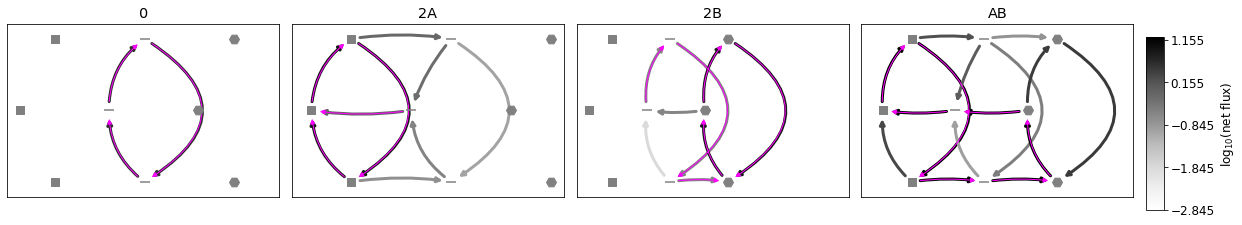

16566
[8.23291386e+01 1.34188965e+00 1.39572439e+03 4.32623064e+01]
[ 82.32913857   1.34188965 140.25574708  43.26230641]
[  82.32913857 1341.88965437 1395.72438898   43.26230641]
[1.9112603162795168, 0.9722970016354284, [0.852992032732431, 1.2190726893222297, 2.337145360424613, 4.585390075596127]]


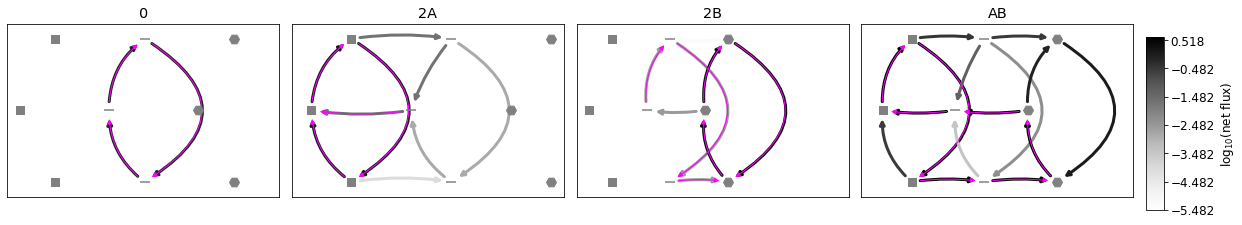

17711
[5.50664869e+01 1.00000000e+00 1.00000000e+04 1.72961212e+03]
[5.50664869e+01 1.00000000e+00 6.64030732e+03 1.72961212e+03]
[   55.06648685  1000.         10000.          1729.61211787]
[3.220582846827099, 0.095042889254521, [0.8898919815625159, 0.9185899842252238, 8.016835747819187, 8.562759499022913]]


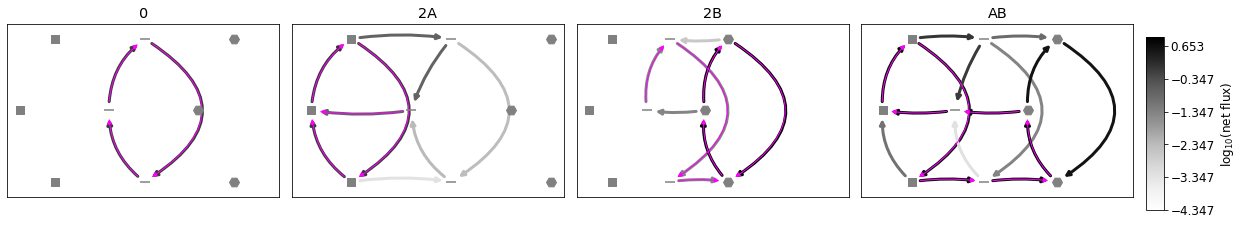

3545
[8.22450081e+02 1.00000000e+00 3.44853274e+03 3.80210937e+01]
[822.45008081   1.           3.44853274  38.02109367]
[ 822.45008081  499.79424533 3448.53274171   38.02109367]
[3.842531396746163, 0.9630273784862498, [0.8788906727684257, 0.9717430834505444, 7.1510290167017, 13.940189189915765]]


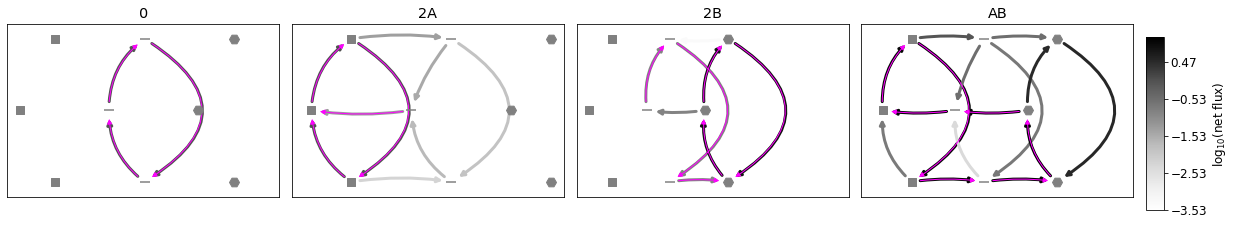

54119
[ 793.7467919     1.79516542 1416.56221347   44.54647576]
[793.7467919    1.79516542  10.          44.54647576]
[ 793.7467919   802.79441595 1416.56221347   44.54647576]
[3.4047360804034397, 0.24360719651495635, [1.6107657145758267, 1.7154007841928436, 15.344764178393799, 18.16742147835377]]


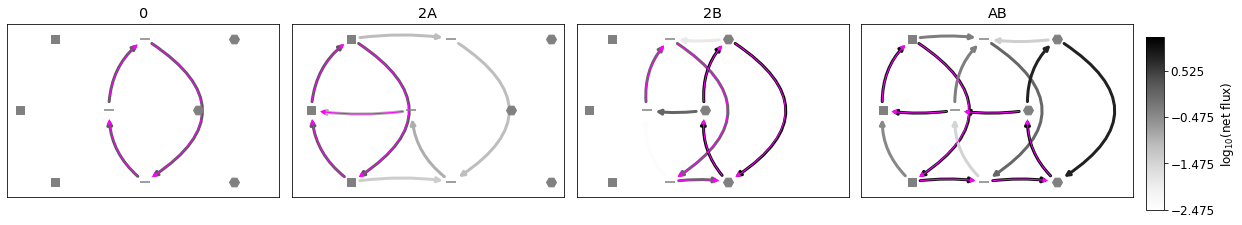

52090
[  7.49758955   8.32049947 142.90976083  17.93424725]
[ 7.49758955  8.32049947  1.         17.93424725]
[  7.49758955 115.95587587 142.90976083  17.93424725]
[-0.5959301939647347, 1.3895148846653045, [0.7287917569664608, 3.141277567541563, 0.7932823461621099, 2.0783249401970645]]


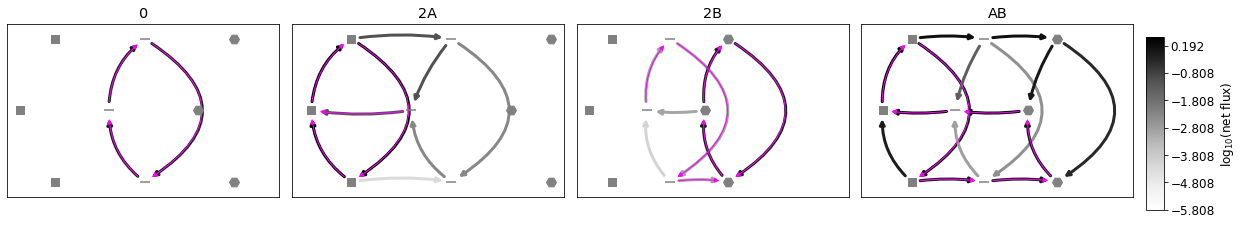

44540
[4.43085590e+03 1.00000000e+00 1.00000000e+04 2.95838118e+01]
[4.43085590e+03 1.00000000e+00 1.48135931e+02 2.95838118e+01]
[ 4430.85589872  1000.         10000.            29.58381182]
[4.078050094138233, 0.8590161152737942, [0.9006442466086698, 0.9644611400446561, 8.980706812677624, 16.289214264489477]]


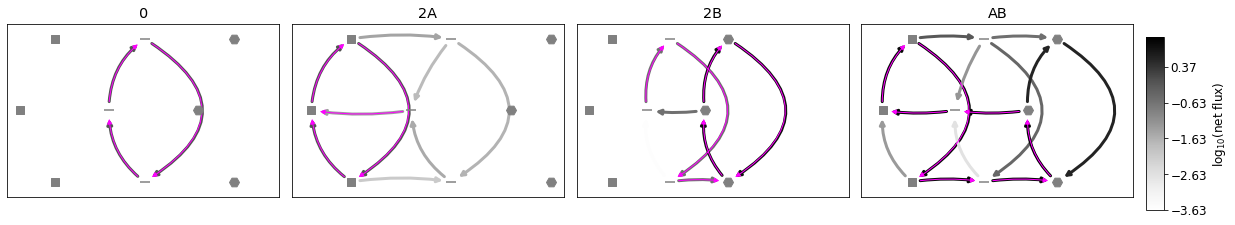

30533
[14.95026665  1.         14.07994037  1.        ]
[14.95026665  1.          1.          1.        ]
[14.95026665 22.27601265 14.07994037  1.        ]
[0.39017426341851763, 0.22209059993141617, [0.33237237031380307, 0.43098277557890474, 0.4842371872090736, 0.564825207523067]]


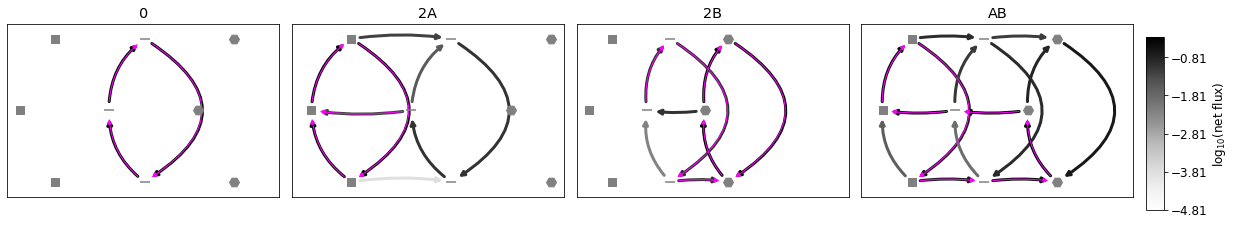

9975
[3.79444330e+02 1.00000000e+00 1.00000000e+04 2.09088779e+02]
[379.44432962   1.          10.         209.08877892]
[  379.44432962  1000.         10000.           209.08877892]
[5.093056888900786, 2.1850922965219057, [0.88225292862616, 0.9907004593892221, 7.435786866583476, 33.81467810452489]]


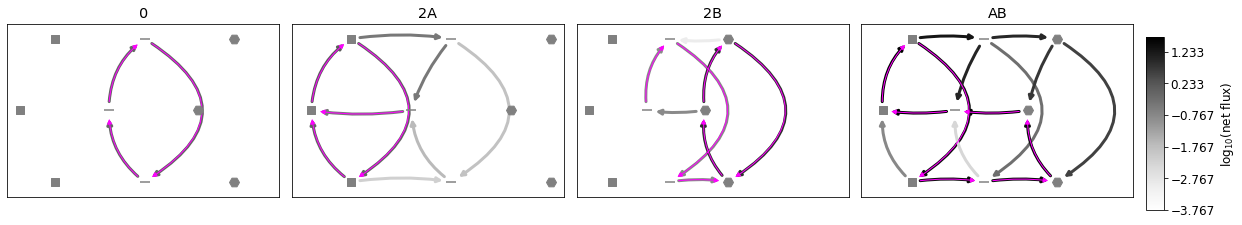

59892
[9.09160541e+02 1.00000000e+00 2.87883108e+03 2.96352334e+01]
[909.16054088   1.          82.77912853  29.63523343]
[ 909.16054088 1000.         2878.83108025   29.63523343]
[3.801170046584502, 0.9366657471757918, [0.8758931691815767, 0.9621607849149482, 7.00727834636009, 13.412627237832247]]


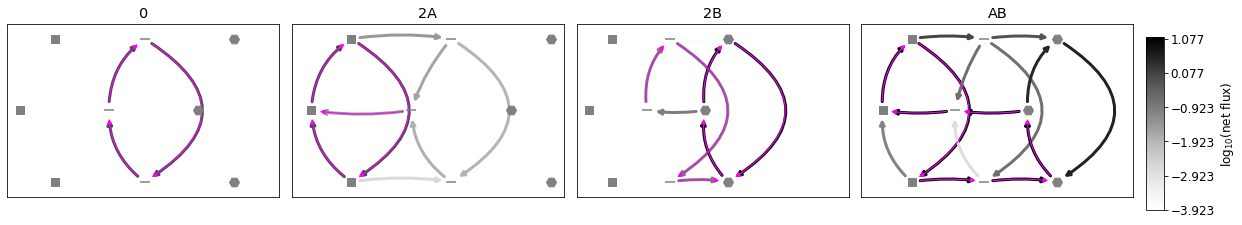

6530
[ 31.18618418   1.         460.78641088  14.73776625]
[31.18618418  1.          1.         14.73776625]
[  31.18618418 1000.          460.78641088   14.73776625]
[1.8312829130582964, 1.8263931432527485, [0.47563155970131654, 0.9031628812190282, 0.906229191840749, 3.213935581543772]]


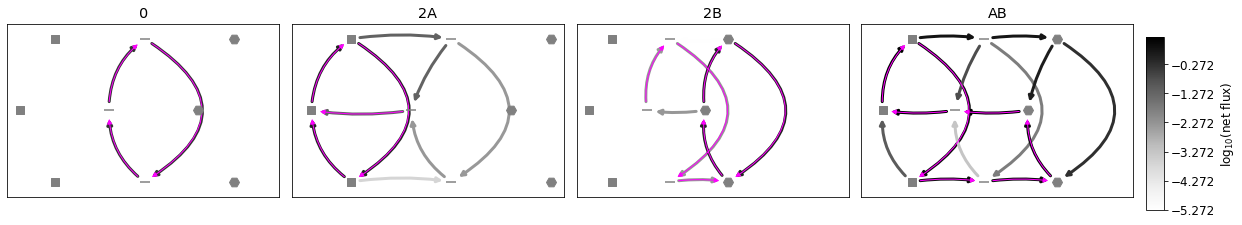

39310
[8.81739810e+01 1.00000000e+00 1.00000000e+04 4.40701588e+01]
[88.173981    1.         10.         44.07015877]
[   88.173981    1000.         10000.            44.07015877]
[2.838496004164825, 4.157359288523196, [0.27720200071996753, 0.9563773491877886, 0.3833644812403843, 6.840718535933408]]


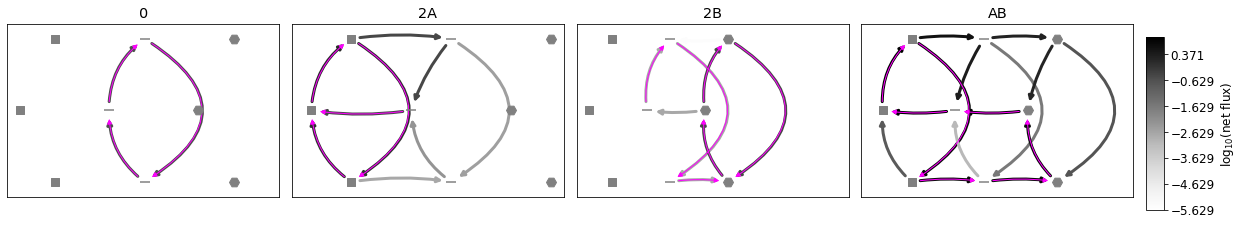

8783
[1.41541456e+02 1.00000000e+00 1.00000000e+04 1.23098465e+02]
[141.54145648   1.          10.         123.09846502]
[  141.54145648  1000.         10000.           123.09846502]
[3.97675805504338, 3.188308025766893, [0.6292771347625329, 0.9810740727337739, 1.6945286166983773, 15.446328209082445]]


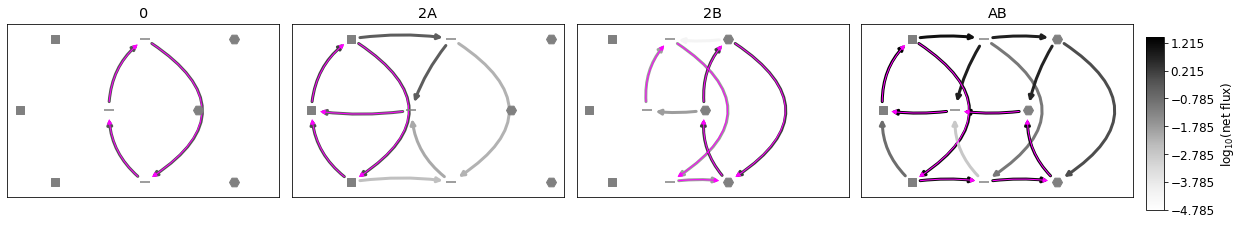

7868
[ 41.11460014   1.53543445 275.336901   125.79165908]
[ 41.11460014   1.53543445  93.75775223 125.79165908]
[  41.11460014 1535.43445436  275.336901    125.79165908]
[3.2842267342711775, 0.2572037959085799, [1.3572374767861008, 1.4235800387308075, 11.603969850861247, 13.86860086115448]]


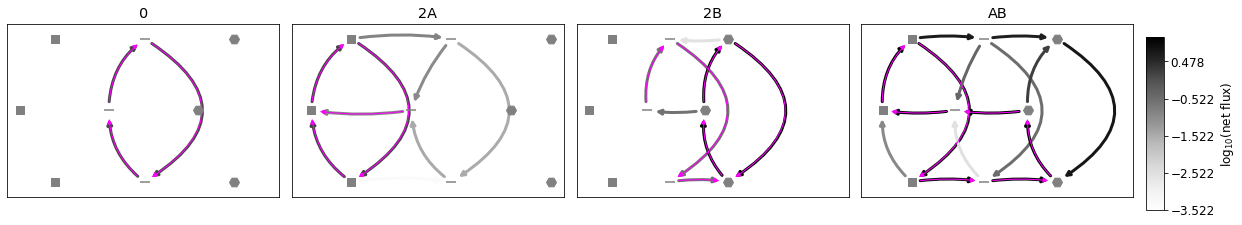

2121
[3.68733306e+02 1.00000000e+00 1.00000000e+04 2.60906776e+01]
[368.73330559   1.         111.81540745  26.09067763]
[  368.73330559    72.6906222  10000.            26.09067763]
[2.3567023494731743, 2.4105270935590783, [0.4806567681727719, 0.9485863080459238, 0.9138480495511679, 4.858642556126788]]


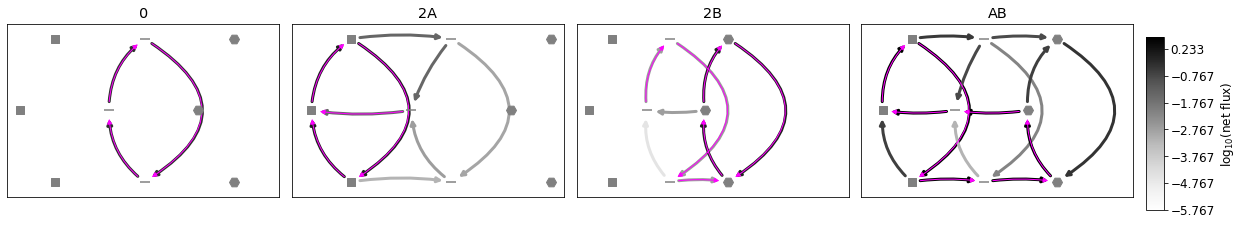

52918
[ 122.0398515     1.52446905 1358.4875822    32.1981584 ]
[122.0398515    1.52446905   3.98511793  32.1981584 ]
[ 122.0398515    92.54244242 1358.4875822    32.1981584 ]
[2.1658500435273567, 1.3454268542746386, [0.9606733104451233, 1.43037930459859, 2.525941027780649, 6.418551750742364]]


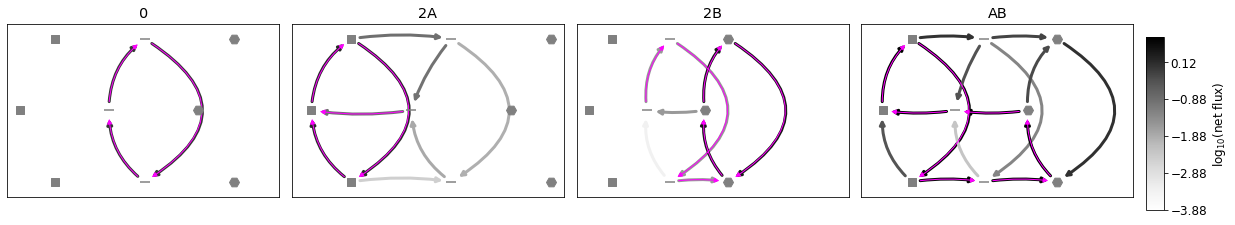

5598
[ 34.52953238   3.62611324 140.22385581  27.12283805]
[34.52953238  3.62611324  1.         27.12283805]
[ 34.52953238  81.11928353 140.22385581  27.12283805]
[0.902589273564957, 0.31323909049266735, [2.035279544934938, 2.916368843895791, 4.387877888790992, 5.451912725978721]]


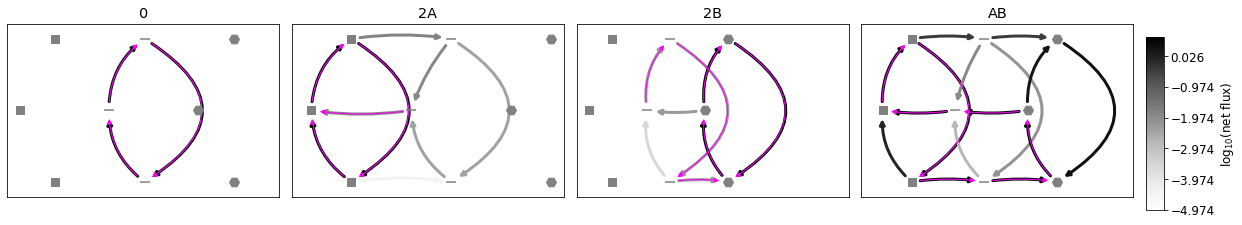

34274
[5.38840727e+02 1.00000000e+00 1.00000000e+04 6.41118406e+01]
[538.84072681   1.          48.79202685  64.1118406 ]
[  538.84072681  1000.         10000.            64.1118406 ]
[4.108974880950562, 2.3795838662197517, [0.765156546492733, 0.9793630728511683, 3.247448664285956, 16.8992883140847]]


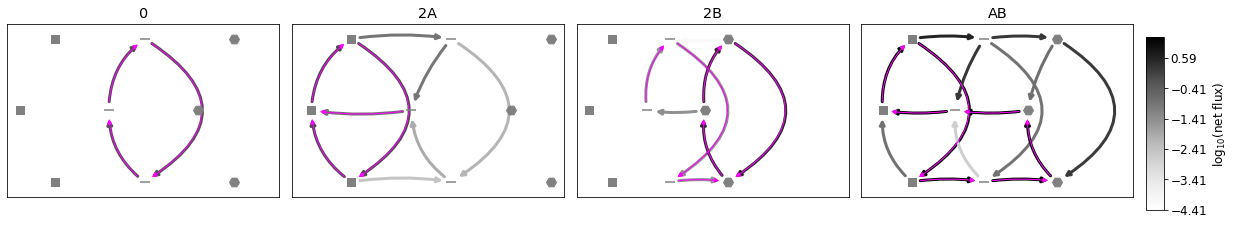

8672
[2.30035968e+02 1.00000000e+00 1.00000000e+04 8.13700951e+01]
[230.03596777   1.          10.          81.37009505]
[  230.03596777  1000.         10000.            81.37009505]
[3.9131530425132937, 3.0218757559246465, [0.6447950471105681, 0.9768578253799847, 1.8118930435680203, 14.71661075800813]]


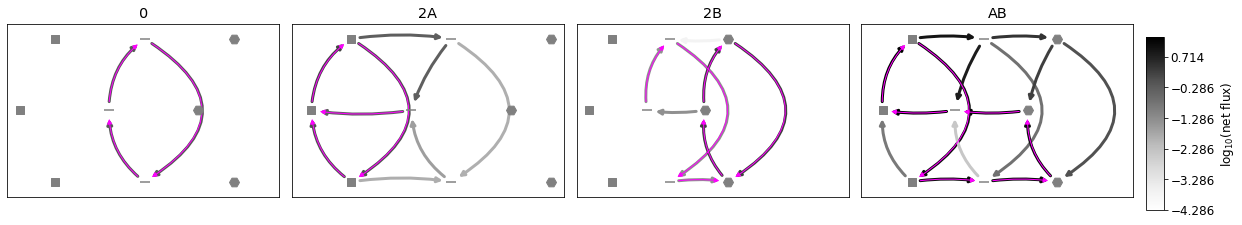

7065
[1021.69716535    7.24581271   13.38320906   32.90244797]
[1.02169717e+03 7.24581271e+00 1.00000000e+00 3.29024480e+01]
[1021.69716535 7245.81270636   13.38320906   32.90244797]
[2.386181260361065, -0.02177958604713711, [5.889957956849471, 5.9014964359055515, 31.320637444297535, 30.85135787811474]]


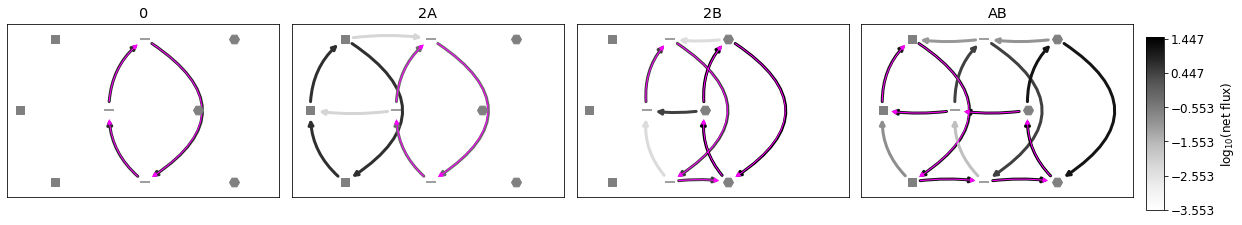

29089
[2.13876083e+02 1.00000000e+00 1.00000000e+04 9.08493862e+01]
[213.87608295   1.          43.53614339  90.84938616]
[  213.87608295   975.00854786 10000.            90.84938616]
[3.958375298529328, 3.014865022330748, [0.6534506953754646, 0.9785285969159653, 1.8819081216838416, 15.211191053338904]]


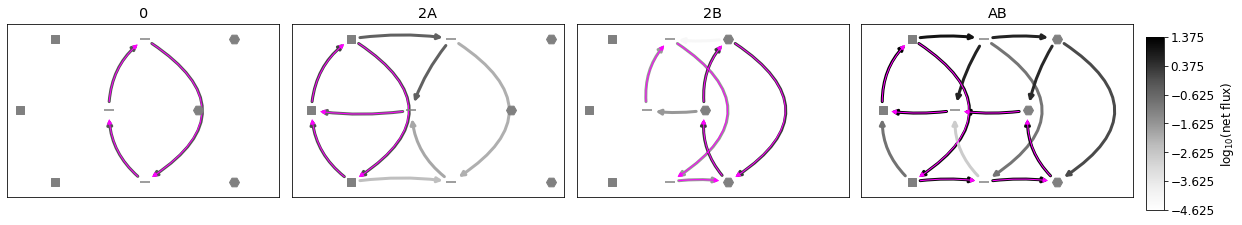

33181
[ 63.03736878   1.         588.81534121  66.40873036]
[ 63.03736878   1.         123.37105865  66.40873036]
[  63.03736878 1000.          588.81534121   66.40873036]
[3.1167259783663956, 0.4917299897391032, [0.8535503199582297, 0.9387759709583336, 5.791145758039997, 8.143103833515855]]


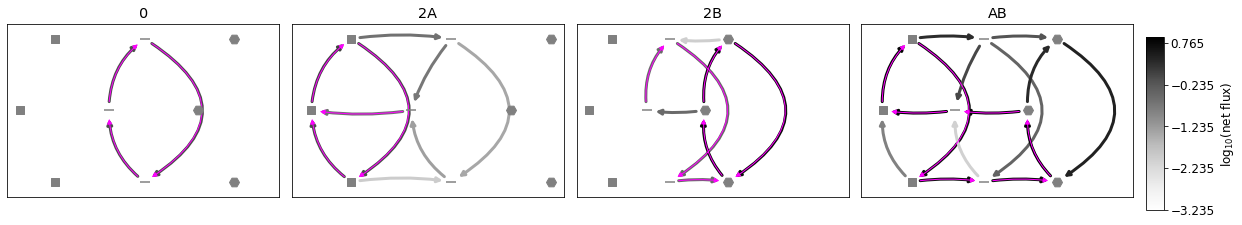

5667
[7.64357574e+00 1.00000000e+00 2.40040728e+03 2.16384083e+02]
[  7.64357574   1.           3.58767312 216.38408289]
[   7.64357574    5.33371707 2400.40728443  216.38408289]
[0.3414187013607967, 0.9628272153834215, [0.38658252405633864, 0.8453507641899606, 0.5495084148109997, 1.0710610343511044]]


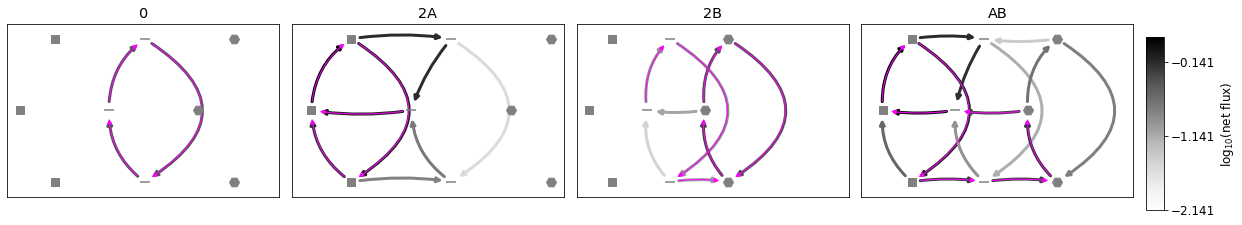

28411
[6.88612717e+02 1.00000000e+00 1.00000000e+04 1.43284381e+02]
[6.88612717e+02 1.00000000e+00 7.36757073e+03 1.43284381e+02]
[  688.61271737  1000.         10000.           143.28438106]
[3.435352474617909, 0.14380631543204278, [0.9010779727673514, 0.9201930283006277, 9.010171648674495, 9.954583162199123]]


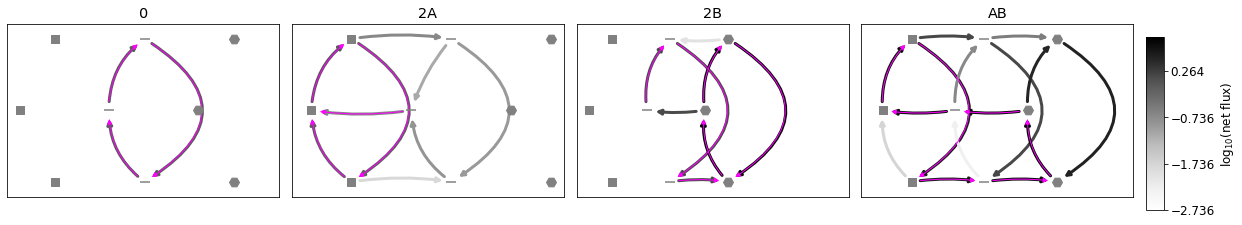

54133
[1.78470018e+02 1.00000000e+00 1.00000000e+04 5.89432345e+01]
[178.47001824   1.          10.          58.94323447]
[  178.47001824   355.36694915 10000.            58.94323447]
[3.401219223300191, 3.3175588744878217, [0.50679738633306, 0.9667930696192915, 1.02451377721828, 10.214157177532782]]


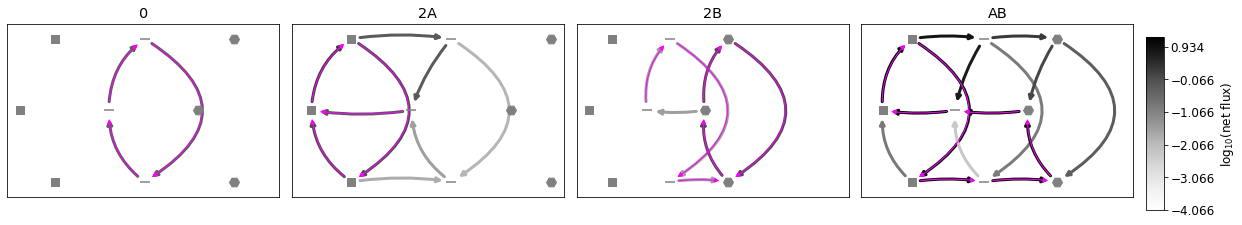

49698
[1.50478148e+02 1.00000000e+00 1.00000000e+04 1.09263687e+02]
[150.47814811   1.          10.         109.26368656]
[  150.47814811  1000.         10000.           109.26368656]
[3.946950622874272, 3.239256698104726, [0.6157621544500779, 0.9796534978379197, 1.5999617219514635, 15.108558216620526]]


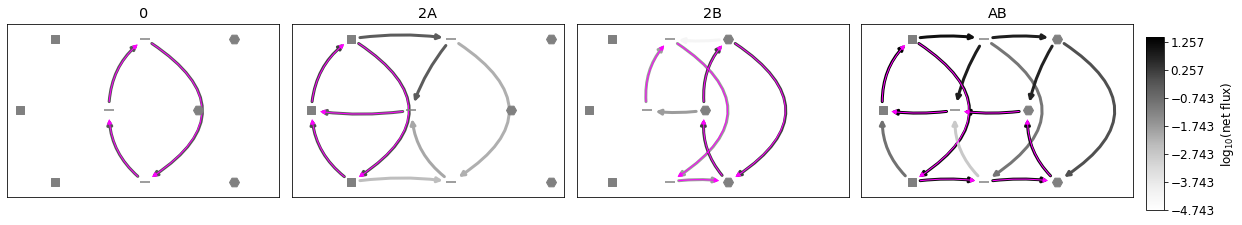

44332
[2.01045478e+03 1.00000000e+00 1.00000000e+04 3.28706371e+01]
[2.01045478e+03 1.00000000e+00 6.11925864e+01 3.28706371e+01]
[ 2010.45477912   571.51226989 10000.            32.87063709]
[3.9028941653533593, 1.4126526394512573, [0.8458518567916776, 0.9671192093036658, 5.433972112355026, 14.466658285163426]]


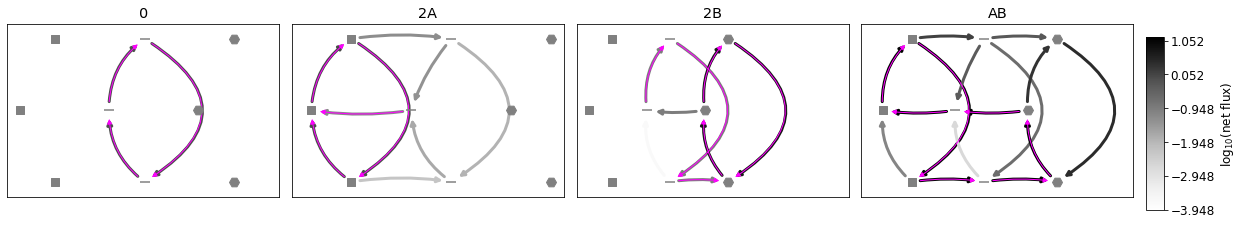

10916
[9.61087177e+01 1.32383693e+00 1.00000000e+04 1.03820023e+02]
[9.61087177e+01 1.32383693e+00 2.47627380e+03 1.03820023e+02]
[   96.10871767   498.10380749 10000.           103.82002347]
[1.0562029576322438, 1.0556979507530841, [0.5625496426987868, 0.9759803780505971, 0.9763220740190746, 2.029503749824467]]


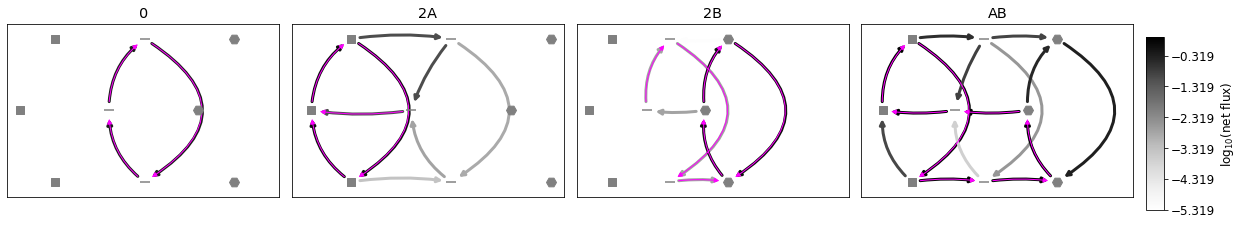

37067
[5.04694737e+02 1.00000000e+00 2.94705769e+03 1.05208194e+01]
[504.69473671   1.          88.82820714  10.52081943]
[ 504.69473671 1000.         2947.05769255   10.52081943]
[1.8595622249252497, 0.9754622050542058, [0.605307401751122, 0.8277671827535058, 1.5277378191891455, 3.0039466344019536]]


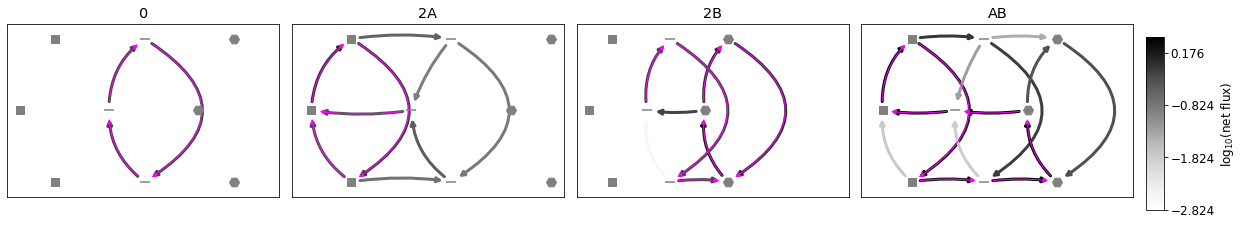

1585
[3.54439390e+02 1.00000000e+00 1.54014441e+03 1.02860927e+01]
[354.43939009   1.         266.84524492  10.28609274]
[ 354.43939009   71.40387859 1540.14441242   10.28609274]
[1.8881880274734368, 0.7520387763623801, [0.6568214009664827, 0.8476119346104425, 1.862996621026219, 3.137605205088164]]


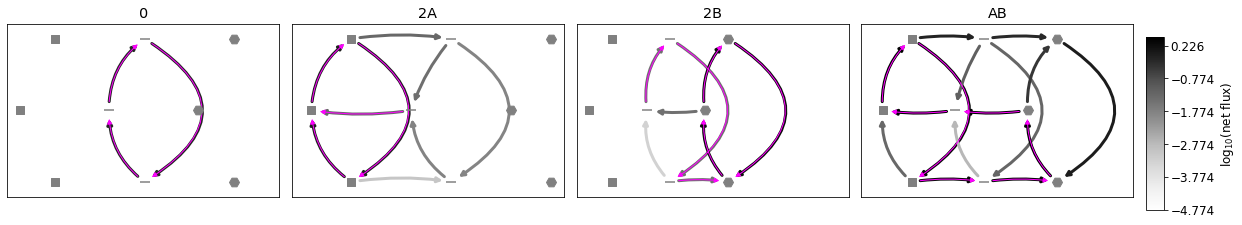

55221
[1.58922098e+02 1.00000000e+00 1.00000000e+04 1.51488320e+02]
[158.92209829   1.          10.         151.48831984]
[  158.92209829  1000.         10000.           151.48831984]
[4.234658176518605, 2.990590194817537, [0.7001502156770845, 0.9834661065051437, 2.3294917484587656, 18.514778885131594]]


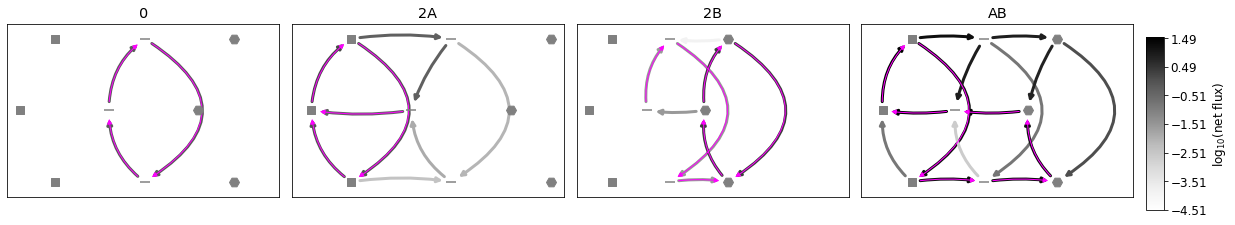

In [18]:
netJ=True
columns_print=["p%d"%i for i in range(1,13)]
#choose 100
np.random.seed(1)
choice=np.random.choice(idxs,size=100,replace=False)
for idx in choice:
    print(idx)
    print(subset.iloc[idx][columns_print[0:4]].values)
    print(subset.iloc[idx][columns_print[4:8]].values)
    print(subset.iloc[idx][columns_print[8:12]].values)
    parset=subset.iloc[idx].values[0:24].copy()
    out=basic.compute_synergy(parset,PolAB_A_allpars.interface_GRF_PolAB_A_A,fcind=10,fcpair=10,returnm=True,anystronger=True)
    print(out)
    allGslist=[]
    allG2slist=[]
    allcolorslist=[]
    fig,axes=plt.subplots(1,4,figsize=(16,3))
    titles=["0","2A","2B","AB"]
    for i in range(4):
        if i==0:
            A=0
            B=0
        elif i==1:
            A=2
            B=0
        elif i==2:
            A=0
            B=2
        else:
            A=1
            B=1
        rhos=PolAB_A_allpars.interface_rhos_GRF_PolAB_A_A(parset,np.array([B]),A)
        P=rhos/np.sum(rhos)
        J=fluxes.get_fluxes(edges_,A,B,parset,P,netJ=netJ)
        Js_ar=J.flatten()
        #print(Js_ar)
        #keep only those columns with nonzero fluxes
        mask=[]
        for col in range(nnodes*nnodes):
            if np.any(Js_ar[col]>1e-15):
                mask.append(col)
        #mat=np.log10(all_Js)[:,mask]
        Js_ar=Js_ar[mask]
        names_ar=all_fnames[mask]
        G=fluxes.get_graph_fromJarray(np.log10(Js_ar),names_ar,min_=-15)
        Gs=[G]
        G2=fluxes.get_dominant_path_G(G,node0)
        all_G2s=[G2]
        allGslist.append(Gs)
        allG2slist.append(all_G2s)
        colors_=[[G[e[0]][e[1]]["weight"] for e in G.edges()] for G in Gs]
        allcolorslist.append(colors_)
    
    vmin_nflog=min([min([min(x) for x in colors_]) for colors_ in allcolorslist])
    vmax_nflog=max([max([max(x) for x in colors_]) for colors_ in allcolorslist])
     
    color_args={"edge_cmap":cmap,"edge_vmin":vmin_nflog,"edge_vmax":vmax_nflog,"width":3}

    
    for i in range(4):
        axes[i].set_title(titles[i])
        #axes[i].set_frame_on(False)
        Gs=allGslist[i]
        all_G2s=allG2slist[i]
        colors_=allcolorslist[i]
        fluxes.plot_graphs(Gs,[axes[i]],coords=coords,dominant=all_G2s,color_lists=colors_,color_args=color_args,colord="magenta")

    cbax=fig.add_axes([1,0,0.015,0.8])
    norm=mpl.colors.Normalize(vmin=vmin_nflog,vmax=vmax_nflog)
    mpl.colorbar.ColorbarBase(cbax,cmap=cmap,norm=norm,ticks=np.arange(vmin_nflog,vmax_nflog,1),label="log$_{10}$(net flux)")
    plt.tight_layout()
    plt.show()
       
